In [450]:
import pandas as pd
import numpy as np
import unicodedata
import os
import time
import random
import re
from nba_api.stats.endpoints import leaguedashplayerstats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from hyperopt import fmin, tpe, Trials, STATUS_OK, hp
from typing import List, Tuple
from plotnine import *
import requests
from bs4 import BeautifulSoup

In [ ]:
# Setting environment variables
START_YEAR = 2004
END_YEAR = 2024
PRED_YEAR = END_YEAR + 1

# Defining URL for pulling NBA projections
FANTASYPROS_URL = "https://www.fantasypros.com/nba/stats/overall.php"

# Define set of NBA team abbreviations (current + recent expansion/contraction awareness)
NBA_TEAMS = {
    "ATL",
    "BOS",
    "BKN",
    "CHA",
    "CHI",
    "CLE",
    "DAL",
    "DEN",
    "DET",
    "GSW",
    "HOU",
    "IND",
    "LAC",
    "LAL",
    "MEM",
    "MIA",
    "MIL",
    "MIN",
    "NOP",
    "NYK",
    "OKC",
    "ORL",
    "PHI",
    "PHX",
    "POR",
    "SAC",
    "SAS",
    "TOR",
    "UTA",
    "WAS",
}

# Selecting columns to keep for the model
selected_columns = [
    "player_id",
    "player_name_clean",
    "season",
    "year",
    "age",
    "pts",
    "reb",
    "ast",
    "gp",
    "usg_pct",
    "w",
    "w_pct",
    "min",
    "fgm",
    "fga",
    "fg_pct",
    "fg3m",
    "fg3a",
    "fg3_pct",
    "ftm",
    "fta",
    "ft_pct",
    "oreb",
    "dreb",
    "reb",
    "ast",
    "tov",
    "stl",
    "blk",
    "blka",
    "pf",
    "pfd",
    "plus_minus",
    "dd2",
    "td3",
    "min_rank",
    "fgm_rank",
    "fg_pct_rank",
    "fg3a_rank",
    "fg3_pct_rank",
    "ftm_rank",
    "fta_rank",
    "oreb_rank",
    "reb_rank",
    "ast_rank",
    "tov_rank",
    "stl_rank",
    "blk_rank",
    "pf_rank",
    "pfd_rank",
    "nba_fantasy_pts_rank",
    "off_rating",
    "def_rating",
    "net_rating",
    "ast_pct",
    "ast_to",
    "ast_ratio",
    "oreb_pct",
    "reb_pct",
    "tm_tov_pct",
    "efg_pct",
    "ts_pct",
    "pace",
    "pie",
    "fgm_pg",
    "fga_pg",
    "playoff_age",
    "playoff_gp",
    "playoff_w_pct",
    "playoff_min",
    "playoff_pts",
    "playoff_usg_pct",
    "playoff_fga",
    "playoff_fta",
    "playoff_ft_pct",
    "playoff_reb",
    "playoff_ast",
    "playoff_stl",
    "playoff_blk",
    "playoff_nba_fantasy_pts",
    "playoff_plus_minus",
    "playoff_efg_pct",
    "playoff_off_rating",
    "playoff_net_rating",
    "playoff_ast_to",
    "playoff_efg_pct",
    "playoff_pie",
    "playoff_fgm_pg",
    "playoff_fga_pg",
]

bref_cols = [
    "player_name_clean",
    "year",
    "age",
    "team",
    "pos",
    "trb_pg",
    "ast_pg",
    "stl_pg",
    "blk_pg",
    "tov_pg",
    "pts_pg",
    "ortg",
    "drtg",
    "3par",
    "ftr",
    "orbpct",
    "drbpct",
    "astpct",
    "stlpct",
    "blkpct",
    "tovpct",
    "ows",
    "dws",
    "ws",
    "ws/48",
    "obpm",
    "dbpm",
    "bpm",
    "vorp",
    "awards",
    "rookie_year",
    "was_drafted",
    "pk",
    "college",
    "all_star",
    "all_def",
    "dpoy",
    "mvp",
    "all_nba",
    "roy",
]

# Core stats for tracking career totals and year over year statistical differences
core_stats = [
    "gp",
    "pts",
    "ast",
    "reb",
    "blk",
    "stl",
    "fg3m",
    "playoff_pts",
    "usg_pct",
    "ws",
    "obpm",
    "dbpm",
    "bpm",
    "vorp",
    "all_star",
    "all_nba_points",
    "fantasy_points",
]

# Dictionary for name overrides to ensure matching names between datasets
name_overrides = {
    "jimmy butler iii": "jimmy butler",
    "kevin knox ii": "kevin knox",
    "marcus morris sr": "marcus morris",
    "reggie bullock jr": "reggie bullock",
    "robert williams iii": "robert williams",
    "xavier tillman sr": "xavier tillman",
    "brandon boston jr": "brandon boston",
    "gg jackson ii": "gg jackson",
    "trey jemison iii": "trey jemison",
}

# Awards that come with a ranking (MVP-11, CPOY-1, etc.)
RANKED_AWARDS = {
    "MVP": "mvp_rank",
    "CPOY": "cpoy_rank",
    "DPOY": "dpoy_rank",
    "6MOY": "smoy_rank",  # Sixth Man
    "MIP": "mip_rank",
    "ROY": "roy_rank",
}

# Tokens that mean "this player made the All-Star team"
ALL_STAR_TOKENS = {"AS"}

# All-NBA team points
ALL_NBA_POINTS = {
    "NBA1": 3,
    "NBA2": 2,
    "NBA3": 1,
}

# Pastel-ish palette with blue as primary
COLOR_PALETTE = [
    "#6baed6",  # primary blue
    "#fdae6b",  # stronger orange
    "#c7e9b4",  # green-ish
    "#dadaeb",  # pale purple
    "#fdd0a2",  # soft orange
    "#9ecae1",  # light blue
]

In [438]:
def get_multi_season_base_and_advanced_stats(
    start_year: int, end_year: int, min_minutes: int = 300
) -> pd.DataFrame:
    """
    Pulls and merges NBA player stats (base + advanced) for regular season,
    and merges playoff base stats as suffix columns for the same player-season.

    Returns:
        pd.DataFrame: Merged and filtered player stats.
    """
    all_season_data = []

    for year in range(start_year, end_year + 1):
        season_str = f"{year}-{str(year + 1)[-2:]}"
        print(f"Fetching data for {season_str}...")

        # === Regular Season (Base + Advanced) ===
        time.sleep(1)
        base = leaguedashplayerstats.LeagueDashPlayerStats(
            season=season_str,
            season_type_all_star="Regular Season",
            measure_type_detailed_defense="Base",
        ).get_data_frames()[0]

        time.sleep(1)
        adv = leaguedashplayerstats.LeagueDashPlayerStats(
            season=season_str,
            season_type_all_star="Regular Season",
            measure_type_detailed_defense="Advanced",
        ).get_data_frames()[0]

        base["SEASON"] = season_str
        adv["SEASON"] = season_str

        base["YEAR"] = year + 1  # For 2022-23, this will be 2023

        # Drop overlapping columns in advanced before merge
        shared_cols = [
            col
            for col in adv.columns
            if col in base.columns and col not in ["PLAYER_ID", "SEASON"]
        ]
        adv_filtered = adv.drop(columns=shared_cols)

        regular_df = pd.merge(
            base, adv_filtered, on=["PLAYER_ID", "SEASON"], how="left"
        )

        # Filtering the regular season data to only include players with enough minutes
        regular_df = regular_df[regular_df["MIN"] >= min_minutes]

        # === Playoffs Data Pull (Base Only) ===
        try:
            time.sleep(1)
            playoff_base = leaguedashplayerstats.LeagueDashPlayerStats(
                season=season_str,
                season_type_all_star="Playoffs",
                measure_type_detailed_defense="Base",
            ).get_data_frames()[0]

            time.sleep(1)
            playoff_adv = leaguedashplayerstats.LeagueDashPlayerStats(
                season=season_str,
                season_type_all_star="Regular Season",
                measure_type_detailed_defense="Advanced",
            ).get_data_frames()[0]

            playoff_base["SEASON"] = season_str
            playoff_adv["SEASON"] = season_str

            # Drop overlapping columns in advanced before merge
            shared_cols = [
                col
                for col in playoff_adv.columns
                if col in playoff_base.columns and col not in ["PLAYER_ID", "SEASON"]
            ]
            playoff_adv_filtered = adv.drop(columns=shared_cols)

            playoff_df = pd.merge(
                playoff_base,
                playoff_adv_filtered,
                on=["PLAYER_ID", "SEASON"],
                how="left",
            )

            # Keep only players with at least min_minutes in playoffs
            playoff_df = playoff_df[playoff_df["MIN"] >= min_minutes]

            # Rename columns (except keys) to add "playoff_" prefix
            playoff_df = playoff_df.rename(
                columns={
                    col: f"playoff_{col}"
                    for col in playoff_df.columns
                    if col not in ["PLAYER_ID", "SEASON"]
                }
            )

            # Merge playoff stats onto regular_df
            merged = pd.merge(
                regular_df, playoff_df, on=["PLAYER_ID", "SEASON"], how="left"
            )

        except Exception as e:
            print(f"Playoff data not available for {season_str}: {e}")
            merged = regular_df  # Use regular season only if playoffs not available

        # Filter to only include NBA players
        merged = merged[merged["TEAM_ABBREVIATION"].isin(NBA_TEAMS)]

        # Drop WNBA-related columns
        merged = merged.loc[:, ~merged.columns.str.contains("WNBA")]

        # Create cleaned player name for merging
        merged["player_name_clean"] = merged["PLAYER_NAME"].apply(clean_name)

        all_season_data.append(merged)

    return pd.concat(all_season_data, ignore_index=True)


def clean_name(name: str) -> str:
    """
    Cleans and normalizes player names by removing punctuation,
    suffixes, and converting accented characters to ASCII.
    """

    # Normalize accented characters to ASCII
    name = (
        unicodedata.normalize("NFKD", str(name))
        .encode("ascii", "ignore")
        .decode("utf-8")
    )

    # Clean punctuation, suffixes, and formatting
    name = (
        name.replace(".", "")
        .replace("*", "")
        .replace("'", "")
        .replace("-", " ")
        .replace(" jr", "")
        .replace(" iii", "")
        .lower()
        .strip()
    )

    return name


def save_dataframe_to_csv(df: pd.DataFrame, path: str):
    """
    Saves a DataFrame to a CSV file, creating directories as needed.

    Parameters:
        df (pd.DataFrame): The DataFrame to save.
        path (str): File path to write the CSV to.
    """
    import os

    os.makedirs(os.path.dirname(path), exist_ok=True)
    df.to_csv(path, index=False)
    print(f"Saved DataFrame to: {path}")

In [463]:
def pull_bref_table(start_year, end_year, table_type):
    bref_list = []
    for year in range(start_year, end_year + 1):
        season_end = year + 1  # BRef uses the END year in its URL
        url = f"https://www.basketball-reference.com/leagues/NBA_{season_end}_{table_type}.html"
        print(f"Pulling {table_type} table for {year}-{str(season_end)[-2:]} season...")
        df = pd.read_html(url, header=0)[0]
        df = df[df["Rk"] != "Rk"]
        df["year"] = season_end  # keep consistency with URL naming
        bref_list.append(df)
        time.sleep(4 + random.random() * 2)
    return pd.concat(bref_list, ignore_index=True)


def pull_bref_draft_table(start_year, end_year):
    all_drafts = []
    for year in range(start_year, end_year + 1):
        url = f"https://www.basketball-reference.com/draft/NBA_{year}.html"
        print(f"Pulling draft table for {year}...")
        tables = pd.read_html(url, header=[0, 1])
        for table in tables:
            table.columns = flatten_multiindex_columns(table)
            # Find the relevant columns by suffix
            col_pk = [c for c in table.columns if c.endswith("Pk")][0]
            col_player = [c for c in table.columns if c.endswith("Player")][0]
            col_college = [c for c in table.columns if c.endswith("College")][0]
            # Subset and rename
            clean = table[[col_pk, col_player, col_college]].copy()
            clean.columns = ["Pk", "Player", "College"]
            clean["draft_year"] = year
            # Drop rows where Pk is "Pk" or is null
            clean = clean[(clean["Pk"] != "Pk") & (clean["Pk"].notnull())]

            all_drafts.append(clean)
        time.sleep(4 + random.random() * 2)

    draft_df = pd.concat(all_drafts, ignore_index=True)

    # Convert Pk to numeric for sorting
    draft_df["Pk"] = pd.to_numeric(draft_df["Pk"], errors="coerce")

    # Keep only the best (lowest) draft pick per player name
    # Sort by Player and Pk, then keep first occurrence
    draft_df = draft_df.sort_values(["Player", "Pk"]).drop_duplicates(
        subset=["Player"], keep="first"
    )

    return draft_df


def flatten_multiindex_columns(df):
    return [
        "_".join([str(x) for x in col if "Unnamed" not in str(x)]).strip("_")
        for col in df.columns
    ]


def get_player_column(df):
    for col in df.columns:
        col_str = str(col)
        if col_str.strip().lower().startswith("player"):
            return col
    raise ValueError("No player column found!")


def keep_tot_or_first(df, team_col="Tm", player_col="Player", year_col="year"):
    # Keep the TOT row for each player/year, or if not present, the first row
    df = df.sort_values([player_col, year_col, team_col])
    result = []
    for (player, year), group in df.groupby([player_col, year_col]):
        if "TOT" in group[team_col].values:
            result.append(group[group[team_col] == "TOT"].iloc[0])
        else:
            result.append(group.iloc[0])
    return pd.DataFrame(result)


def expand_awards(
    df, player_col="player_name_clean", year_col="year", awards_col="Awards"
):
    """
    Expands a compact Awards column like "DPOY-11,DEF1" into one-hot / ranked award columns.
    Each Award_* column contains the numeric rank, or 1 if no rank is specified.

    Parameters:
        df (pd.DataFrame): Input dataframe
        player_col (str): Column containing player names
        year_col (str): Column containing the season year
        awards_col (str): Column containing the raw awards string

    Returns:
        pd.DataFrame: Wide-format dataframe with award columns expanded
    """
    # Keep only rows with awards
    awards_df = df[df[awards_col].notna() & (df[awards_col] != "")].copy()

    # Split awards string on commas
    awards_df["Award_List"] = awards_df[awards_col].str.split(",")

    # Explode list into rows
    awards_df = awards_df.explode("Award_List")
    awards_df["Award_List"] = awards_df["Award_List"].str.strip()

    # Extract award type (e.g., "DPOY" or "DEF") and rank (e.g., 11)
    awards_df["Award_Type"] = awards_df["Award_List"].apply(
        lambda x: (
            re.sub(r"[\d\-]+", "", x).strip().replace(" ", "_")
            if isinstance(x, str)
            else None
        )
    )
    awards_df["Award_Rank"] = awards_df["Award_List"].apply(
        lambda x: (
            int(re.search(r"\d+$", x).group())
            if isinstance(x, str) and re.search(r"\d+$", x)
            else 1
        )
    )

    # Pivot wider
    awards_wide = (
        awards_df[[player_col, year_col, "Award_Type", "Award_Rank"]]
        .pivot_table(
            index=[player_col, year_col],
            columns="Award_Type",
            values="Award_Rank",
            fill_value=0,
            aggfunc="first",
        )
        .reset_index()
    )

    # Rename ambiguous columns in the awards_wide DataFrame
    rename_map = {
        "AS": "all_star",
        "DEF": "all_def",
        "NBA": "all_nba",
    }

    # Apply rename
    awards_wide = awards_wide.rename(columns=rename_map)

    return awards_wide

In [440]:
def get_combined_bref_data(start_year, end_year):
    adv_df = pull_bref_table(start_year, end_year, "advanced")
    per_poss_df = pull_bref_table(start_year, end_year, "per_poss")

    # Pull *extra* draft years (back 15 years)
    draft_df = pull_bref_draft_table(max(2000, start_year - 15), end_year)

    def get_col(cols, ending):
        return [c for c in cols if ending.lower() in c.lower()][0]

    adv_player_col = get_col(adv_df.columns, "player")
    adv_team_col = get_col(adv_df.columns, "team")
    per_poss_player_col = get_col(per_poss_df.columns, "player")
    per_poss_team_col = get_col(per_poss_df.columns, "team")
    draft_player_col = "Player"

    adv_df = keep_tot_or_first(
        adv_df, team_col=adv_team_col, player_col=adv_player_col, year_col="year"
    )
    per_poss_df = keep_tot_or_first(
        per_poss_df,
        team_col=per_poss_team_col,
        player_col=per_poss_player_col,
        year_col="year",
    )

    adv_df["player_name_clean"] = adv_df[adv_player_col].apply(clean_name)
    per_poss_df["player_name_clean"] = per_poss_df[per_poss_player_col].apply(
        clean_name
    )
    draft_df["player_name_clean"] = draft_df[draft_player_col].apply(clean_name)

    # Merge advanced and per_poss (as before)
    combined = adv_df.merge(
        per_poss_df[
            ["player_name_clean", "year"]
            + [
                col
                for col in per_poss_df.columns
                if col not in [per_poss_player_col, "Rk", "year", "player_name_clean"]
            ]
        ],
        on=["player_name_clean", "year"],
        how="outer",
        suffixes=("", "_perposs"),
    )

    # Merge draft info (by player only, not by year)
    combined = combined.merge(
        draft_df[["player_name_clean", "draft_year", "Pk", "College"]],
        on="player_name_clean",
        how="left",
        suffixes=("", "_draft"),
    )

    # Fill null College values with 'NO COLLEGE'
    combined["College"] = combined["College"].fillna("NO COLLEGE")

    # Determine rookie year for each player
    combined["rookie_year"] = combined.groupby("player_name_clean")["year"].transform(
        "min"
    )

    # Designate undrafted players
    combined["was_drafted"] = combined["Pk"].notna().astype(int)

    # Columns to rename to per-game equivalents within the final DataFrame
    rename_map = {
        "TRB": "TRB_pg",
        "AST": "AST_pg",
        "STL": "STL_pg",
        "BLK": "BLK_pg",
        "TOV": "TOV_pg",
        "PTS": "PTS_pg",
    }

    # Apply rename
    combined = combined.rename(columns=rename_map)

    # Fixing the Awards column format so that awards voting ranks are numeric and placing into the final output Dataframe
    expanded = expand_awards(combined[["player_name_clean", "year", "Awards"]])

    final = combined.merge(expanded, on=["player_name_clean", "year"], how="left")

    # If you want to keep draft info ONLY for rookie year:
    # combined.loc[combined['year'] != combined['rookie_year'], ['Pk', 'College']] = pd.NA

    return final

In [441]:
def clean_and_refine_nba_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Cleans the NBA DataFrame by normalizing column names and removing unnecessary columns.

    Parameters:
        df (pd.DataFrame): The DataFrame to clean.

    Returns:
        pd.DataFrame: Cleaned DataFrame.
    """
    # Normalize column names to lower case and replace spaces and percentage signs
    df.columns = df.columns.str.lower().str.replace(" ", "_").str.replace("%", "pct")

    # Ensuring that statistical columns are numeric
    for col in df.columns:
        if df[col].dtype == "object":
            try:
                df[col] = pd.to_numeric(df[col])
            except ValueError:
                continue

    # Fill missing with zero for numeric stats that can't be negative
    stat_cols = [col for col in df.columns if df[col].dtype in ["float64", "int64"]]
    df[stat_cols] = df[stat_cols].fillna(0)

    return df

In [442]:
api_df = get_multi_season_base_and_advanced_stats(
    start_year=START_YEAR, end_year=END_YEAR
)

Fetching data for 2004-05...
Fetching data for 2005-06...
Fetching data for 2006-07...
Fetching data for 2007-08...
Fetching data for 2008-09...
Fetching data for 2009-10...
Fetching data for 2010-11...
Fetching data for 2011-12...
Fetching data for 2012-13...
Fetching data for 2013-14...
Fetching data for 2014-15...
Fetching data for 2015-16...
Fetching data for 2016-17...
Fetching data for 2017-18...
Fetching data for 2018-19...
Fetching data for 2019-20...
Fetching data for 2020-21...
Fetching data for 2021-22...
Fetching data for 2022-23...
Fetching data for 2023-24...
Fetching data for 2024-25...


In [444]:
display(api_df)

,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM_ABBREVIATION,AGE,GP,W,L,W_PCT,...,playoff_TS_PCT_RANK,playoff_USG_PCT_RANK,playoff_E_USG_PCT_RANK,playoff_E_PACE_RANK,playoff_PACE_RANK,playoff_sp_work_PACE_RANK,playoff_PIE_RANK,playoff_FGM_PG_RANK,playoff_FGA_PG_RANK,player_name_clean
0,243,Aaron McKie,Aaron,1610612755,PHI,32.0,68,35,33,0.515,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,aaron mckie
1,1425,Aaron Williams,Aaron,1610612761,TOR,33.0,42,13,29,0.310,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,aaron williams
2,1502,Adonal Foyle,Adonal,1610612744,GSW,30.0,78,31,47,0.397,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,adonal foyle
3,1559,Adrian Griffin,Adrian,1610612741,CHI,30.0,69,38,31,0.551,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,adrian griffin
4,1733,Al Harrington,Al,1610612737,ATL,25.0,66,10,56,0.152,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,al harrington
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7854,1641744,Zach Edey,Zach,1610612763,MEM,23.0,66,35,31,0.530,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,zach edey
7855,203897,Zach LaVine,Zach,1610612758,SAC,30.0,74,32,42,0.432,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,zach lavine
7856,1630192,Zeke Nnaji,Zeke,1610612743,DEN,24.0,57,36,21,0.632,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,zeke nnaji
7857,1630533,Ziaire Williams,Ziaire,1610612751,BKN,23.0,63,22,41,0.349,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ziaire williams


In [467]:
bref_df = get_combined_bref_data(start_year=START_YEAR, end_year=END_YEAR)

Pulling advanced table for 2004-05 season...
Pulling advanced table for 2005-06 season...
Pulling advanced table for 2006-07 season...
Pulling advanced table for 2007-08 season...
Pulling advanced table for 2008-09 season...
Pulling advanced table for 2009-10 season...
Pulling advanced table for 2010-11 season...
Pulling advanced table for 2011-12 season...
Pulling advanced table for 2012-13 season...
Pulling advanced table for 2013-14 season...
Pulling advanced table for 2014-15 season...
Pulling advanced table for 2015-16 season...
Pulling advanced table for 2016-17 season...
Pulling advanced table for 2017-18 season...
Pulling advanced table for 2018-19 season...
Pulling advanced table for 2019-20 season...
Pulling advanced table for 2020-21 season...
Pulling advanced table for 2021-22 season...
Pulling advanced table for 2022-23 season...
Pulling advanced table for 2023-24 season...
Pulling advanced table for 2024-25 season...
Pulling per_poss table for 2004-05 season...
Pulling pe

In [468]:
display(bref_df)

,Rk,Player,Age,Team,Pos,G,GS,MP,PER,TS%,...,was_drafted,all_star,CPOY,all_def,DPOY,MIP,MOY,MVP,all_nba,ROY
0,306.0,Aaron Brooks,23.0,HOU,PG,51.0,0.0,608.0,13.1,0.535,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,130.0,Aaron Brooks,24.0,HOU,PG,80.0,35.0,1998.0,12.9,0.521,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,16.0,Aaron Brooks,25.0,HOU,PG,82.0,82.0,2919.0,16.0,0.549,...,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,221.0,Aaron Brooks,26.0,2TM,PG,59.0,12.0,1284.0,13.1,0.489,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,264.0,Aaron Brooks,28.0,2TM,PG,53.0,20.0,997.0,11.8,0.555,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10489,216.0,Zydrunas Ilgauskas,34.0,CLE,C,64.0,6.0,1339.0,11.9,0.491,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10490,237.0,Zydrunas Ilgauskas,35.0,MIA,C,72.0,51.0,1145.0,12.8,0.531,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10491,475.0,Zylan Cheatham,24.0,NOP,PF,4.0,0.0,51.0,6.7,0.667,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10492,590.0,Zylan Cheatham,26.0,UTA,SF,1.0,0.0,5.0,-23.8,0.000,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
## TODO: Create function to skip data load and read datasets from CSV files if they exist
## TODO: Include minutes per game from basketball reference, include minutes per game in the core stats
## TODO: Add 3 year player averages for core stats
## TODO: Create a flag to denote COVID-impacted season
## TODO: Create tracker for number of games missed due to injury in career (games played / total games possible)
## TODO: Add an injury flag which denotes whether a player missed significant time due to injury, not benching (e.g., more than 20 games missed & over 15 minutes per game)

In [ ]:
# Saving the api_df and bref_df to CSV files for future reference
# save_dataframe_to_csv(
#     api_df, path=f"data/api_player_stats_{START_YEAR}_{END_YEAR}.csv"
# )
# save_dataframe_to_csv(
#     bref_df, path=f"data/bref_player_stats_{START_YEAR}_{END_YEAR}.csv"
# )

Saved DataFrame to: data/api_player_stats_2004_2024.csv
Saved DataFrame to: data/bref_player_stats_2004_2024.csv


In [470]:
api_df = clean_and_refine_nba_data(api_df)
api_df["player_name_clean"] = api_df["player_name_clean"].replace(name_overrides)

# Keep only selected columns for the model
api_df = api_df[selected_columns]

In [471]:
bref_df = clean_and_refine_nba_data(bref_df)
bref_df["player_name_clean"] = bref_df["player_name_clean"].replace(name_overrides)

# Keep only selected columns for the model
bref_df = bref_df[bref_cols]

In [472]:
display(api_df)

,player_id,player_name_clean,season,year,age,pts,reb,ast,gp,usg_pct,...,playoff_nba_fantasy_pts,playoff_plus_minus,playoff_efg_pct,playoff_off_rating,playoff_net_rating,playoff_ast_to,playoff_efg_pct,playoff_pie,playoff_fgm_pg,playoff_fga_pg
0,243,aaron mckie,2004-05,2005,32.0,152,172,103,68,0.068,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1425,aaron williams,2004-05,2005,33.0,73,60,8,42,0.128,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1502,adonal foyle,2004-05,2005,30.0,352,429,56,78,0.104,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1559,adrian griffin,2004-05,2005,30.0,151,146,53,69,0.136,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1733,al harrington,2004-05,2005,25.0,1158,461,208,66,0.236,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7854,1641744,zach edey,2024-25,2025,23.0,610,548,65,66,0.156,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7855,203897,zach lavine,2024-25,2025,30.0,1724,315,310,74,0.251,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7856,1630192,zeke nnaji,2024-25,2025,24.0,184,90,23,57,0.119,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7857,1630533,ziaire williams,2024-25,2025,23.0,632,287,84,63,0.179,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [473]:
display(bref_df)

,player_name_clean,year,age,team,pos,trb_pg,ast_pg,stl_pg,blk_pg,tov_pg,...,rookie_year,was_drafted,pk,college,all_star,all_def,dpoy,mvp,all_nba,roy
0,aaron brooks,2008,23.0,HOU,PG,4.9,7.6,1.1,0.4,3.8,...,2008,1,26.0,Oregon,0.0,0.0,0.0,0.0,0.0,0.0
1,aaron brooks,2009,24.0,HOU,PG,4.2,6.3,1.2,0.2,3.3,...,2008,1,26.0,Oregon,0.0,0.0,0.0,0.0,0.0,0.0
2,aaron brooks,2010,25.0,HOU,PG,3.8,7.6,1.2,0.2,4.1,...,2008,1,26.0,Oregon,0.0,0.0,0.0,0.0,0.0,0.0
3,aaron brooks,2011,26.0,2TM,PG,3.1,9.2,1.3,0.1,3.9,...,2008,1,26.0,Oregon,0.0,0.0,0.0,0.0,0.0,0.0
4,aaron brooks,2013,28.0,2TM,PG,4.1,5.9,1.5,0.5,3.4,...,2008,1,26.0,Oregon,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10489,zydrunas ilgauskas,2010,34.0,CLE,C,13.5,1.9,0.5,2.0,2.5,...,2005,0,0.0,NO COLLEGE,0.0,0.0,0.0,0.0,0.0,0.0
10490,zydrunas ilgauskas,2011,35.0,MIA,C,13.2,1.2,1.1,2.7,2.4,...,2005,0,0.0,NO COLLEGE,0.0,0.0,0.0,0.0,0.0,0.0
10491,zylan cheatham,2020,24.0,NOP,PF,8.2,2.7,0.9,0.9,3.6,...,2020,0,0.0,NO COLLEGE,0.0,0.0,0.0,0.0,0.0,0.0
10492,zylan cheatham,2022,26.0,UTA,SF,0.0,0.0,0.0,0.0,0.0,...,2020,0,0.0,NO COLLEGE,0.0,0.0,0.0,0.0,0.0,0.0


In [474]:
# Merging dataframes together
## Protip, "ws" values will be null for players that did not match correctly on name and year
combined_df = pd.merge(
    api_df,
    bref_df,
    on=["player_name_clean", "year"],
    how="left",
    suffixes=("", "_bref"),
)

# If duplicate columns appear in the dataset, keep only the first occurrence
combined_df = combined_df.loc[:, ~combined_df.columns.duplicated()]

# Drop rows where a player's team information is missing
combined_df = combined_df[combined_df["team"].notna()]

In [475]:
display(combined_df)

,player_id,player_name_clean,season,year,age,pts,reb,ast,gp,usg_pct,...,rookie_year,was_drafted,pk,college,all_star,all_def,dpoy,mvp,all_nba,roy
0,243,aaron mckie,2004-05,2005,32.0,152,172,103,68,0.068,...,2005.0,0.0,0.0,NO COLLEGE,0.0,0.0,0.0,0.0,0.0,0.0
1,1425,aaron williams,2004-05,2005,33.0,73,60,8,42,0.128,...,2005.0,0.0,0.0,NO COLLEGE,0.0,0.0,0.0,0.0,0.0,0.0
2,1502,adonal foyle,2004-05,2005,30.0,352,429,56,78,0.104,...,2005.0,0.0,0.0,NO COLLEGE,0.0,0.0,0.0,0.0,0.0,0.0
3,1559,adrian griffin,2004-05,2005,30.0,151,146,53,69,0.136,...,2005.0,0.0,0.0,NO COLLEGE,0.0,0.0,0.0,0.0,0.0,0.0
4,1733,al harrington,2004-05,2005,25.0,1158,461,208,66,0.236,...,2005.0,0.0,0.0,NO COLLEGE,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7854,1641744,zach edey,2024-25,2025,23.0,610,548,65,66,0.156,...,2025.0,1.0,9.0,Purdue,0.0,0.0,0.0,0.0,0.0,5.0
7855,203897,zach lavine,2024-25,2025,30.0,1724,315,310,74,0.251,...,2015.0,1.0,13.0,UCLA,0.0,0.0,0.0,0.0,0.0,0.0
7856,1630192,zeke nnaji,2024-25,2025,24.0,184,90,23,57,0.119,...,2021.0,1.0,22.0,Arizona,0.0,0.0,0.0,0.0,0.0,0.0
7857,1630533,ziaire williams,2024-25,2025,23.0,632,287,84,63,0.179,...,2022.0,1.0,10.0,Stanford,0.0,0.0,0.0,0.0,0.0,0.0


In [476]:
# Creating a function to assign fantasy points scored in a season
def calculate_fantasy_points(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate total fantasy points for each player-season based on standard Underdog Fantasy scoring.

    Parameters:
        df (pd.DataFrame): DataFrame containing player stats.

    Returns:
        pd.DataFrame: DataFrame with an additional 'fantasy_points' column.
    """
    df["fantasy_points"] = (
        df["pts"] * 1
        + df["reb"] * 1.2
        + df["ast"] * 1.5
        + df["stl"] * 3
        + df["blk"] * 3
        - df["tov"] * 1
    )
    return df

In [477]:
# Separating player awards & achievements into separate columns
def parse_awards_cell(cell: str) -> dict:
    """
    Parse a single awards string like:
      "MVP-11,CPOY-1,AS,NBA3"

    Returns a dict of per-season award metrics.
    """
    # Default resume values for all metrics we care about
    res = {
        "all_nba_team": np.nan,  # 1/2/3 or NaN
        "all_nba_points": 0,  # 3/2/1 or 0
        "mvp_rank": np.nan,
        "cpoy_rank": np.nan,
        "dpoy_rank": np.nan,
        "smoy_rank": np.nan,
        "mip_rank": np.nan,
        "roy_rank": np.nan,
    }

    if not isinstance(cell, str) or cell.strip() == "":
        return res

    for raw_token in cell.split(","):
        token = raw_token.strip()
        if not token:
            continue

        # All-NBA teams (NBA1, NBA2, NBA3)
        if token in ALL_NBA_POINTS:
            res["all_nba_points"] = ALL_NBA_POINTS[token]
            # Last character is the team number: "NBA3" -> 3
            res["all_nba_team"] = int(token[-1])
            continue

        # Ranked awards (MVP-11 etc.)
        if "-" in token:
            award_code, rank_str = token.split("-", 1)
            award_code = award_code.strip().upper()

            try:
                rank = int(rank_str)
            except ValueError:
                # If rank isn't an int, skip
                continue

            col_name = RANKED_AWARDS.get(award_code)
            if col_name is not None:
                res[col_name] = rank

    return res

In [478]:
combined_df = calculate_fantasy_points(combined_df)

In [479]:
awards_parsed = combined_df["awards"].apply(parse_awards_cell)

awards_df = pd.DataFrame(list(awards_parsed), index=combined_df.index)

combined_df = pd.concat([combined_df, awards_df], axis=1)

# Dropping the original Awards column
combined_df = combined_df.drop(columns=["awards"])

In [480]:
# Creating features for tracking core statistical career totals & year-over-year deltas
# This also tracks total fantasy points scored in prior and following seasons
def add_career_and_deltas(df: pd.DataFrame, core_stats: list) -> pd.DataFrame:
    """
    Add per-player career cumulative totals and year-over-year deltas for specified stats.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame containing at minimum 'player_name_clean' and 'year' columns,
        plus any stat columns listed in core_stats.
    core_stats : list
        List of stat column names to compute career sums and year-over-year deltas for.

    Returns
    -------
    pd.DataFrame
        A copy of the input DataFrame with the following additional columns:
        - career_<stat>: cumulative sum of <stat> for each player up to the current row.
        - <stat>_delta: year-over-year difference of <stat> for each player.

    Notes
    -----
    - Non-numeric or missing stat names from core_stats are ignored.
    - Numeric stat NaNs are filled with 0 before calculations.
    - The function sorts by ['player_name_clean', 'year'] and casts 'year' to int.
    """

    # Keep only numeric stats that actually exist
    stats = [
        c
        for c in core_stats
        if c in df.columns and pd.api.types.is_numeric_dtype(df[c])
    ]
    df[stats] = df[stats].fillna(0)
    df["year"] = df["year"].astype(int)

    # Sort & group
    df = df.sort_values(["player_name_clean", "year"])
    g = df.groupby("player_name_clean", sort=False)

    # Career cumulative totals (up to current row)
    career = g[stats].cumsum().add_prefix("career_")

    # Tracking number of unique teams played for in career so far
    # treat '3tm' as 2 teams, otherwise count as 1 (3tm indicates that they played for 2 *new* teams that season)
    # compute weight per row: 2 for '3tm', else 1
    team_weight = (
        df["team"].astype(str).str.lower().apply(lambda t: 2 if "3tm" in t else 1)
    )

    # find first occurrence of each player-team string (so multi-team tokens count once)
    occ = df.groupby(["player_name_clean", "team"], sort=False).cumcount()
    is_first_team_occurrence = (occ == 0).astype(int)

    # cumulative unique-team count weighted by multi-team tokens
    career["career_unique_teams"] = (
        (is_first_team_occurrence * team_weight)
        .groupby(df["player_name_clean"], sort=False)
        .cumsum()
    )

    # year-over-year deltas for all stats at once
    deltas = g[stats].diff().fillna(0)
    deltas.columns = [f"{c}_delta" for c in deltas.columns]

    # Capturing each player's fantasy points in the prior season
    # Helpful for modeling improvement or decline
    deltas["fantasy_points_prior"] = g["fantasy_points"].shift(1).fillna(0)

    # Capturing each player's fantasy points in the following season
    # This will be used as the target variable for modeling
    deltas["fantasy_points_future"] = g["fantasy_points"].shift(-1).fillna(0)

    # attach new metrics onto original dataframe
    return pd.concat([df, career, deltas], axis=1)

In [481]:
combined_df = add_career_and_deltas(combined_df, core_stats)

# Creating age based features
combined_df["years_in_league"] = combined_df["year"] - combined_df["rookie_year"]
combined_df["age_bucket"] = pd.cut(
    combined_df["age"],
    bins=[18, 22, 26, 30, 34, 45],
    labels=["rookie", "young", "prime", "veteran", "late"],
)

In [482]:
# Fixing up columns that need to be reformatted for modeling
# Converting college column to categorical variable
combined_df["college"] = combined_df["college"].astype("category")
combined_df["pos"] = combined_df["pos"].astype("category")
combined_df["team"] = combined_df["team"].astype("category")

In [506]:
display(combined_df)

,player_id,player_name_clean,season,year,age,pts,reb,ast,gp,usg_pct,...,dbpm_delta,bpm_delta,vorp_delta,all_star_delta,all_nba_points_delta,fantasy_points_delta,fantasy_points_prior,fantasy_points_future,years_in_league,age_bucket
980,201166,aaron brooks,2007-08,2008,23.0,264,56,87,51,0.216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1476.4,0.0,young
1301,201166,aaron brooks,2008-09,2009,24.0,894,157,238,80,0.226,...,-0.8,-0.7,0.3,0.0,0.0,1004.7,471.7,2530.0,1.0,young
1632,201166,aaron brooks,2009-10,2010,25.0,1604,215,434,82,0.254,...,-1.0,1.6,1.3,0.0,0.0,1053.6,1476.4,1089.1,2.0,young
1975,201166,aaron brooks,2010-11,2011,26.0,634,78,233,59,0.251,...,-1.1,-3.7,-2.2,0.0,0.0,-1440.9,2530.0,696.0,3.0,young
2671,201166,aaron brooks,2012-13,2013,28.0,376,80,114,53,0.178,...,1.3,0.8,0.3,0.0,0.0,-393.1,1089.1,1240.5,5.0,prime
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,980,zydrunas ilgauskas,2006-07,2007,32.0,925,599,123,78,0.215,...,0.7,-1.2,-0.8,0.0,0.0,-304.4,2429.7,2330.4,2.0,veteran
1300,980,zydrunas ilgauskas,2007-08,2008,33.0,1029,682,104,73,0.225,...,-1.2,-0.8,-0.4,0.0,0.0,205.1,2125.3,1768.0,3.0,veteran
1630,980,zydrunas ilgauskas,2008-09,2009,34.0,838,490,64,65,0.236,...,0.4,0.1,-0.1,0.0,0.0,-562.4,2330.4,1089.0,4.0,veteran
1973,980,zydrunas ilgauskas,2009-10,2010,35.0,474,345,48,64,0.187,...,-0.8,-3.5,-1.4,0.0,0.0,-679.0,1768.0,934.4,5.0,late


## Modeling

In [483]:
def split_data_nba(
    df: pd.DataFrame,
    target_col: str = "fantasy_points_future",
    drop_cols: List[str] = None,
    test_size: float = 0.2,
    random_state: int = 1234,
    pred_year: int = PRED_YEAR,
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """
    Prepare NBA modeling data: remove last season per player (no real future),
    define X/y, and perform train/test split.
    """
    df = df.copy()

    if drop_cols is None:
        drop_cols = [
            "player_name_clean",
            "player_id",
            "season",
        ]

    # Dropping the most recent season for all players (no future data available)
    df = df.loc[df["year"] < pred_year].copy()

    # Dropping any instances where the target variable is zero (no fantasy points in following season)
    # These players were likely ruled out due to injury, retirement, or other reasons
    df = df[df[target_col] > 0].copy()

    # Define target
    y = df[target_col]

    # Define features (all columns except drop_cols + target)
    cols_to_drop = set(drop_cols + [target_col])
    feature_cols = [c for c in df.columns if c not in cols_to_drop]

    X = df[feature_cols]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    return X_train, X_test, y_train, y_test, feature_cols

In [484]:
def scale_numeric_train_test(
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
) -> Tuple[pd.DataFrame, pd.DataFrame, StandardScaler]:
    """
    Fit a StandardScaler on numeric columns of X_train and apply to both X_train/X_test.
    """
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    numeric_cols = X_train.select_dtypes(include=["number"]).columns

    scaler = StandardScaler()
    X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
    X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

    return X_train_scaled, X_test_scaled, scaler

In [485]:
def create_baseline_nba(
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_train: pd.Series,
    y_test: pd.Series,
):
    """
    Create a baseline XGBoost model for predicting future fantasy points
    """
    model = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=1234,
        n_jobs=-1,
        enable_categorical=True,
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"[Baseline] RMSE: {rmse:.3f}")
    print(f"[Baseline] MAE:  {mae:.3f}")
    print(f"[Baseline] R^2:  {r2:.3f}")

    return model, y_pred

In [486]:
def attach_model_results(
    X_test: pd.DataFrame,
    y_pred: np.ndarray,
    source_df: pd.DataFrame,
    result_cols: List[str] = None,
) -> pd.DataFrame:
    """
    Attach model predictions back onto the test set and calculate performance metrics.

    Parameters:
        X_test (pd.DataFrame): Feature matrix from train/test split.
        y_pred (np.ndarray): Model predictions.
        source_df (pd.DataFrame): Original combined DataFrame (to pull player/season info).
        result_cols (List[str]): Columns to include in final results. If None, uses defaults.

    Returns:
        pd.DataFrame: Results DataFrame with predictions, actuals, and differences.
    """
    if result_cols is None:
        result_cols = [
            "player_name_clean",
            "season",
            "year",
            "fantasy_points",
            "fantasy_points_future",
            "predicted_fantasy_points",
            "prediction_diff",
        ]

    results = X_test.copy()
    results["predicted_fantasy_points"] = y_pred

    # Join player/season info from source DataFrame using index alignment
    results = results.join(
        source_df[["player_name_clean", "season", "fantasy_points_future"]], how="left"
    )

    # Calculate prediction difference
    results["prediction_diff"] = round(
        results["predicted_fantasy_points"] - results["fantasy_points_future"], 2
    )

    # Return only specified columns
    return results[result_cols].sort_values(
        by="predicted_fantasy_points", ascending=False
    )

In [487]:
def tune_xgb_nba(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    space: dict,
    metric: str = "rmse",
    alpha: float = 1.5,
    evals: int = 60,
):
    """
    Hyperopt-based tuning of XGBoost for NBA fantasy predictions.
    Uses an internal train/validation split and early stopping.
    """
    # Train/validation split from training data
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=1234
    )

    def asymmetric_loss(y_true, y_pred, alpha=1.5):
        residuals = y_true - y_pred
        loss = np.where(residuals > 0, alpha * (residuals**2), residuals**2)
        return np.mean(loss)

    def objective(params):
        # Cast and unpack params
        max_depth = int(params["max_depth"])

        model = XGBRegressor(
            learning_rate=params["learning_rate"],
            max_depth=max_depth,
            subsample=params["subsample"],
            colsample_bytree=params["colsample_bytree"],
            min_child_weight=params["min_child_weight"],
            reg_lambda=params["reg_lambda"],
            reg_alpha=params["reg_alpha"],
            n_estimators=2000,  # upper bound; early stopping will cut it
            random_state=1234,
            n_jobs=-1,
            tree_method="hist",
            enable_categorical=True,
            eval_metric="rmse",
            early_stopping_rounds=100,
        )

        model.fit(
            X_tr,
            y_tr,
            eval_set=[(X_val, y_val)],
            verbose=False,
        )

        y_pred = model.predict(X_val)

        if metric == "rmse":
            loss = np.sqrt(mean_squared_error(y_val, y_pred))
        elif metric == "mae":
            loss = mean_absolute_error(y_val, y_pred)
        elif metric == "asymmetric":
            loss = asymmetric_loss(y_val, y_pred, alpha=alpha)
        else:
            raise ValueError(f"Unknown metric: {metric}")

        return {"loss": loss, "status": STATUS_OK}

    trials = Trials()

    best_params = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=evals,
        trials=trials,
    )

    # Cast to native types
    best_params["max_depth"] = int(best_params["max_depth"])

    print("Best Parameters:", best_params)
    return best_params

In [488]:
def create_model_nba(
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_train: pd.Series,
    y_test: pd.Series,
    final_params: dict,
):
    """
    Train a final XGBoost model with tuned parameters, using early stopping,
    and evaluate on the held-out test set.
    """

    # Initialize model with tuned params + fixed seeds / options
    model = XGBRegressor(
        **final_params,
        random_state=1234,
        n_jobs=-1,
        eval_metric="rmse",
        enable_categorical=True,
        early_stopping_rounds=100,
    )

    # Fit with early stopping on the training data
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train)],
        verbose=False,
    )

    # Predict on held-out test data
    final_pred = model.predict(X_test)

    # Evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_test, final_pred))
    mae = mean_absolute_error(y_test, final_pred)
    r2 = r2_score(y_test, final_pred)

    print(f"[Final tuned] RMSE: {rmse:.3f}")
    print(f"[Final tuned] MAE:  {mae:.3f}")
    print(f"[Final tuned] R^2:  {r2:.3f}")

    return model, final_pred

## Defining training & testing datasets

In [489]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test, feature_cols = split_data_nba(combined_df)

# Scaling is not explicitly required for tree-based models, but keeping the process for potential future use
# X_train, X_test, scaler = scale_numeric_train_test(X_train, X_test)

## Creating Baseline Model

In [490]:
# Generating baseline model and predictions to measure final model performance
baseline_model, baseline_pred = create_baseline_nba(X_train, X_test, y_train, y_test)

[Baseline] RMSE: 563.312
[Baseline] MAE:  433.044
[Baseline] R^2:  0.542


In [491]:
# Attach baseline model results to testing set for review
results = attach_model_results(X_test, baseline_pred, combined_df)

display(results)

,player_name_clean,season,year,fantasy_points,fantasy_points_future,predicted_fantasy_points,prediction_diff
1835,lebron james,2009-10,2010,4244.3,3888.0,4249.957520,361.96
6914,nikola jokic,2022-23,2023,3842.4,4609.2,3772.424072,-836.78
4720,giannis antetokounmpo,2017-18,2018,3881.1,4045.6,3734.390869,-311.21
6461,luka doncic,2021-22,2022,3451.6,3747.3,3678.441406,-68.86
3249,kevin durant,2013-14,2014,4179.1,1137.6,3666.729980,2529.13
...,...,...,...,...,...,...,...
2125,jason collins,2010-11,2011,279.4,122.6,408.813354,286.21
320,walter mccarty,2004-05,2005,565.1,224.1,408.394226,184.29
5719,semi ojeleye,2019-20,2020,524.5,521.9,380.127502,-141.77
5030,cameron payne,2018-19,2019,561.4,1099.3,327.147491,-772.15


## Creating Final Model

In [492]:
def build_prediction_frame(
    df: pd.DataFrame,
    pred_year: int,
    feature_cols: List[str],
    drop_cols: List[str] = None,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Build the dataframe and feature matrix for making future predictions.

    df_pred: subset of df for pred_year (used to attach predictions back to players)
    X_pred:  features corresponding to those rows
    """
    df = df.copy()

    if drop_cols is None:
        drop_cols = [
            "player_name_clean",
            "player_id",
            "season",
        ]

    # Subset to the season you want to predict
    df_pred = df.loc[df["year"] == pred_year].copy()

    # Ensure all required feature columns exist
    missing = [c for c in feature_cols if c not in df_pred.columns]
    if missing:
        raise ValueError(f"Missing feature columns in prediction frame: {missing}")

    X_pred = df_pred[feature_cols]

    return df_pred, X_pred

In [424]:
def get_xgb_feature_importance(
    model,
    feature_names=None,
    importance_type: str = "gain",
) -> pd.DataFrame:
    """
    Extract XGBoost feature importance as a tidy DataFrame.

    Handles both:
    - boosters where features are named 'f0', 'f1', ...
    - boosters where features are named with actual column names.
    """
    booster = model.get_booster()
    score_dict = booster.get_score(importance_type=importance_type)

    if not score_dict:
        # No importance info, return empty frame
        return pd.DataFrame(columns=["feature", "importance", "rel_importance"])

    # If feature_names not provided, try to use model.feature_names_in_
    if feature_names is None and hasattr(model, "feature_names_in_"):
        feature_names = list(model.feature_names_in_)
    elif feature_names is None:
        feature_names = []

    rows = []

    # Check whether keys look like 'f0', 'f1', ...
    f_pattern = re.compile(r"^f\d+$")
    keys_look_like_f = all(bool(f_pattern.match(k)) for k in score_dict.keys())

    if keys_look_like_f and feature_names:
        # Map 'f0', 'f1', ... to actual feature names by index
        for k, v in score_dict.items():
            idx = int(k[1:])  # drop 'f'
            fname = feature_names[idx] if idx < len(feature_names) else k
            rows.append((fname, v))
    else:
        # Keys are already feature names (e.g. 'year', 'career_pts', ...)
        for k, v in score_dict.items():
            rows.append((k, v))

    df_imp = pd.DataFrame(rows, columns=["feature", "importance"])
    df_imp = df_imp.sort_values("importance", ascending=False)

    total = df_imp["importance"].sum()
    df_imp["rel_importance"] = df_imp["importance"] / total if total > 0 else 0.0

    return df_imp

In [423]:
def theme_nba():
    """
    Custom plotnine theme:
    - serif font
    - classic background
    - no panel borders
    - white figure background
    """
    return theme_classic() + theme(
        text=element_text(family="serif"),
        plot_title=element_text(size=18, weight="bold"),
        axis_title=element_text(size=14),
        axis_text=element_text(size=12),
        legend_title=element_text(size=10),
        legend_text=element_text(size=9),
        # No panel border
        panel_border=element_blank(),
        # White backgrounds
        panel_background=element_rect(fill="white", color=None),
        # Faint major gridlines
        panel_grid_major=element_line(color="#e0e0e0", size=0.4),
        panel_grid_minor=element_line(color="#f0f0f0", size=0.3),
        figure_size=(10, 6),
    )

In [ ]:
def plot_feature_importance(
    model,
    X_train,
    top_n: int = 20,
    importance_type: str = "gain",
):
    """
    Create a plotnine feature importance plot for an XGBoost model.
    """
    feature_names = list(X_train.columns)

    df_imp = get_xgb_feature_importance(
        model,
        feature_names=feature_names,
        importance_type=importance_type,
    )

    df_top = df_imp.head(top_n).copy()

    p = (
        ggplot(df_top, aes(x="reorder(feature, rel_importance)", y="rel_importance"))
        + geom_col(fill="#6baed6", alpha=0.9)
        + coord_flip()
        + labs(
            title="Feature Importance (XGBoost)",
            y="Relative Importance",
        )
        + theme_nba()
        + theme(
            axis_text=element_text(color="black"),
            axis_title_y=element_blank(),
            figure_size=(10, 8),
        )
    )

    return p

In [493]:
# Building a prediction dataframe and feature predictions dataframe
df_pred, X_pred = build_prediction_frame(
    combined_df,
    pred_year=PRED_YEAR,
    feature_cols=feature_cols,
)

In [494]:
# Define Hyperopt search space for final model tuning
space = {
    # Learning Rate and Max Depth
    "learning_rate": hp.uniform("learning_rate", 0.03, 0.2),
    "max_depth": hp.quniform("max_depth", 3, 8, 1),
    # Row and column subsampling
    "subsample": hp.uniform("subsample", 0.7, 1.0),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.7, 1.0),
    # Tree complexity / regularization
    "min_child_weight": hp.uniform("min_child_weight", 1, 10),
    "reg_lambda": hp.uniform("reg_lambda", 0.0, 5.0),  # L2
    "reg_alpha": hp.uniform("reg_alpha", 0.0, 2.0),  # L1
}

# Tune Model
best_params = tune_xgb_nba(
    X_train,
    y_train,
    space=space,
    metric="rmse",
    evals=60,
)

final_model, final_pred = create_model_nba(
    X_train,
    X_test,
    y_train,
    y_test,
    final_params=best_params,
)

  0%|          | 0/60 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 60/60 [01:39<00:00,  1.65s/trial, best loss: 481.06896313577346]
Best Parameters: {'colsample_bytree': np.float64(0.7294079721665299), 'learning_rate': np.float64(0.03332155134695012), 'max_depth': 3, 'min_child_weight': np.float64(6.95449165215051), 'reg_alpha': np.float64(0.9756472907049546), 'reg_lambda': np.float64(0.06847088240311278), 'subsample': np.float64(0.9932868994510555)}
[Final tuned] RMSE: 554.295
[Final tuned] MAE:  434.613
[Final tuned] R^2:  0.557


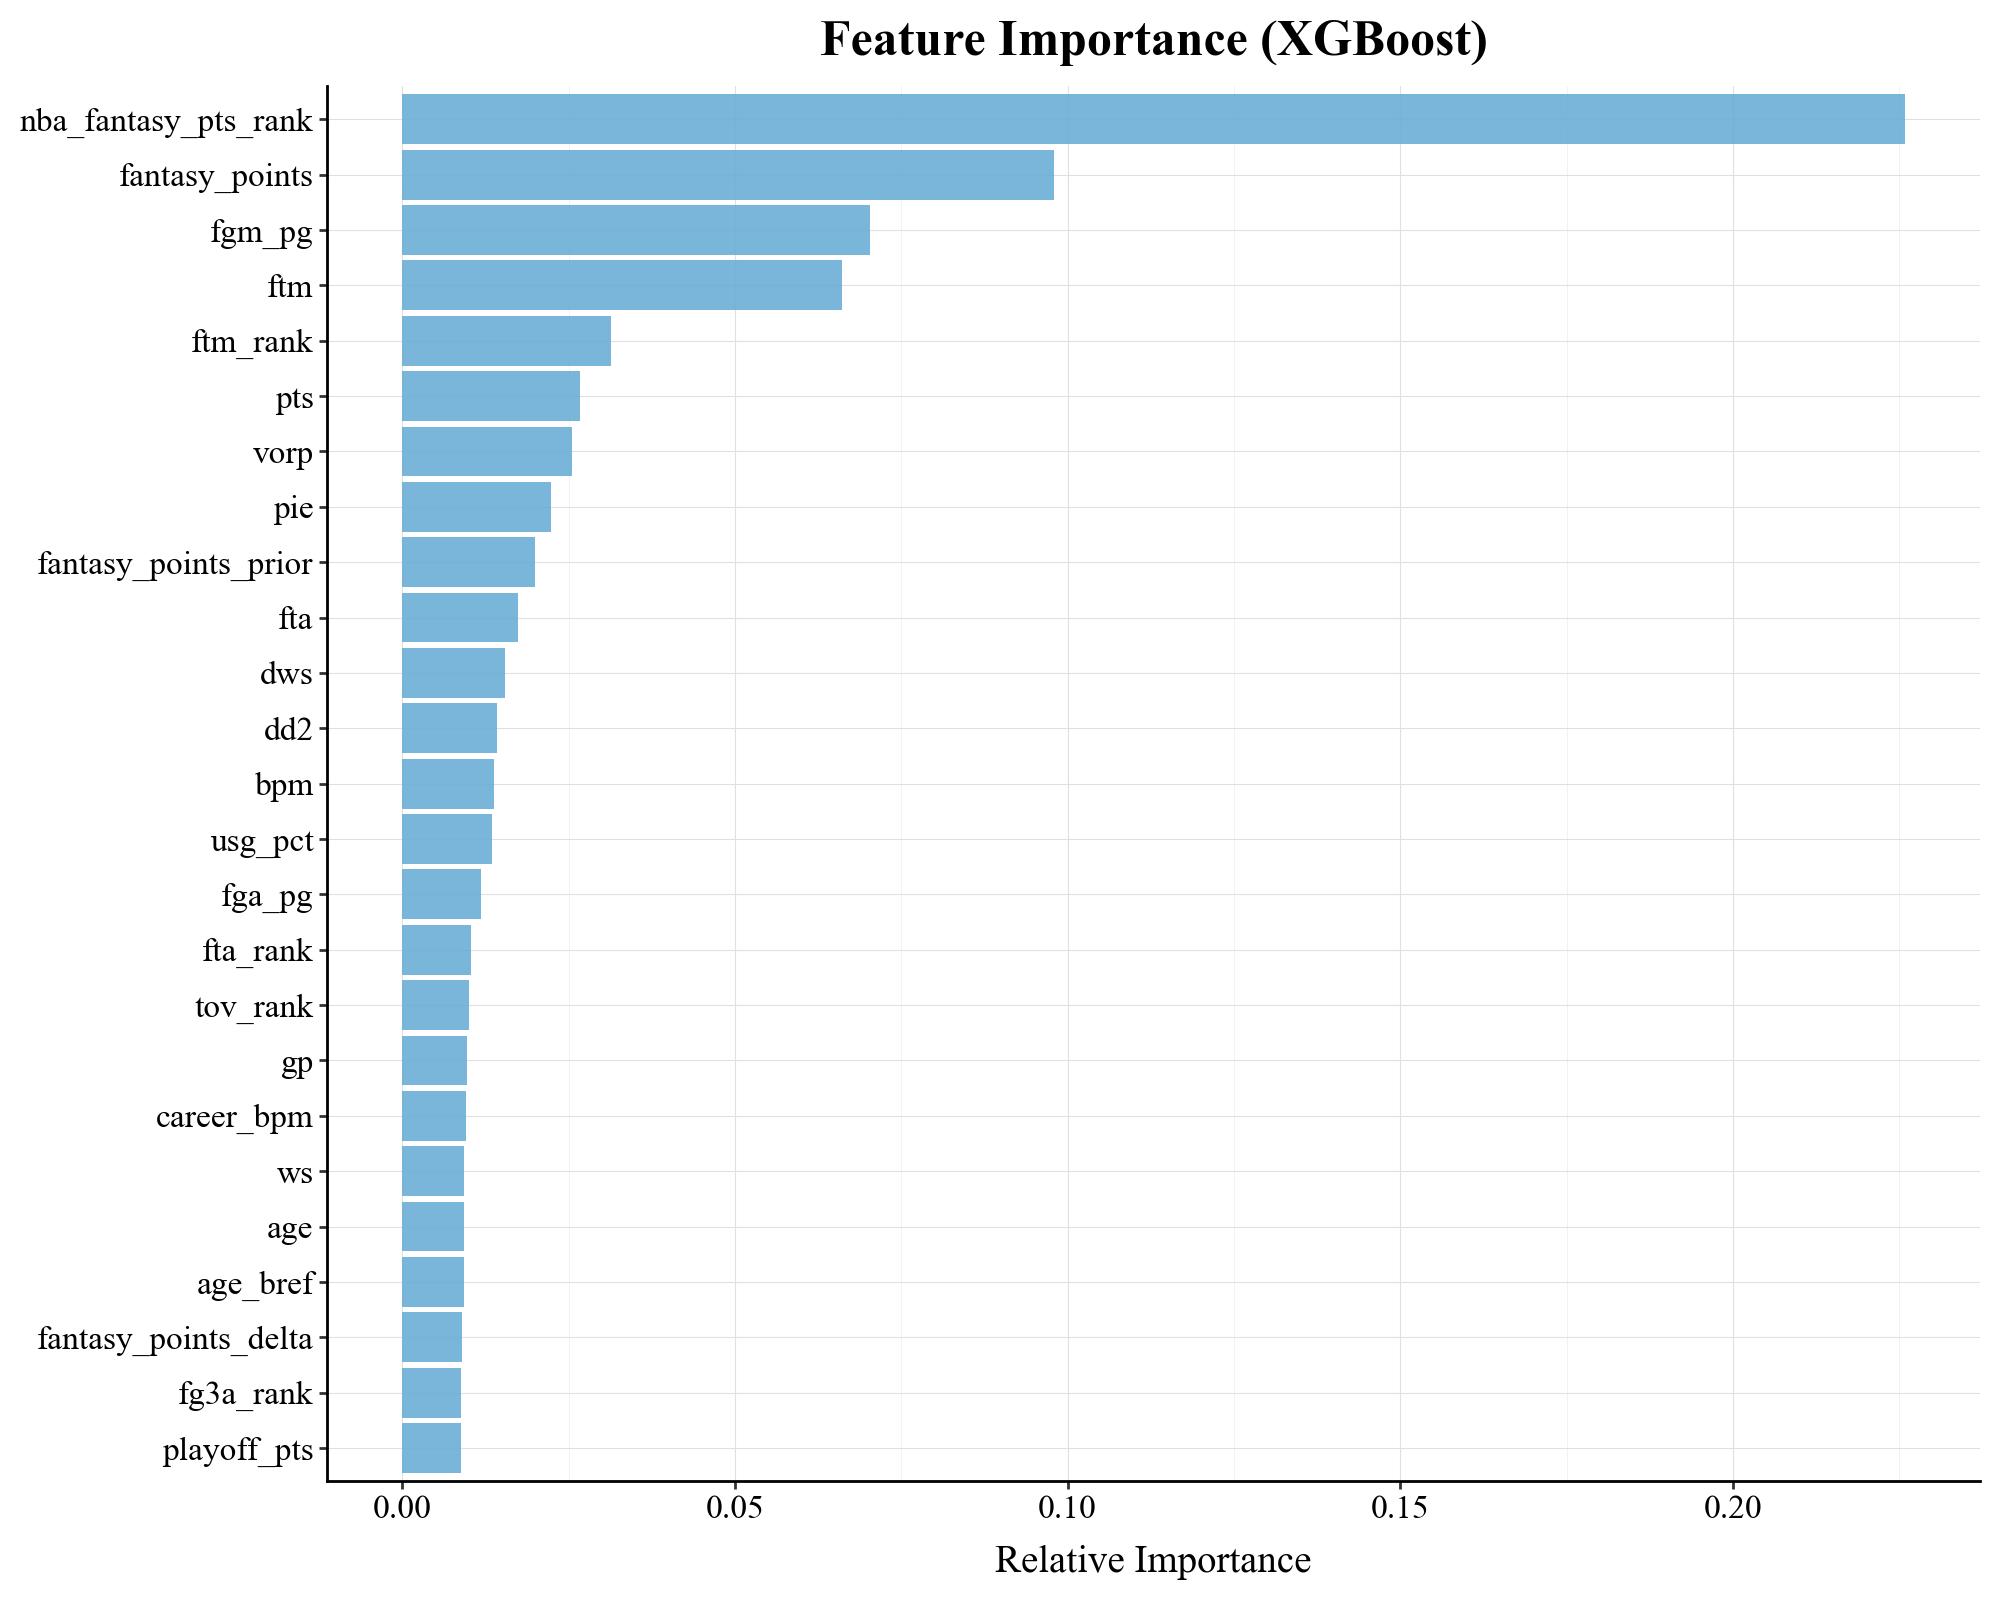

In [495]:
# Plotting out the feature importance of the final model
fi_plot = plot_feature_importance(
    final_model,
    X_train=X_train,  # your training feature frame
    top_n=25,
    importance_type="gain",
)

fi_plot

In [496]:
# Attach final model results to testing set for review
results = attach_model_results(X_test, final_pred, combined_df)

display(results)

,player_name_clean,season,year,fantasy_points,fantasy_points_future,predicted_fantasy_points,prediction_diff
1835,lebron james,2009-10,2010,4244.3,3888.0,3595.517822,-292.48
3249,kevin durant,2013-14,2014,4179.1,1137.6,3587.045898,2449.45
6914,nikola jokic,2022-23,2023,3842.4,4609.2,3408.257812,-1200.94
4720,giannis antetokounmpo,2017-18,2018,3881.1,4045.6,3313.535400,-732.06
6461,luka doncic,2021-22,2022,3451.6,3747.3,3304.354004,-442.95
...,...,...,...,...,...,...,...
2760,derek fisher,2012-13,2013,325.9,916.9,608.283081,-308.62
1604,theo ratliff,2008-09,2009,434.1,581.9,607.908203,26.01
1277,theo ratliff,2007-08,2008,349.8,434.1,606.131287,172.03
834,kevin ollie,2006-07,2007,501.8,502.5,588.856812,86.36


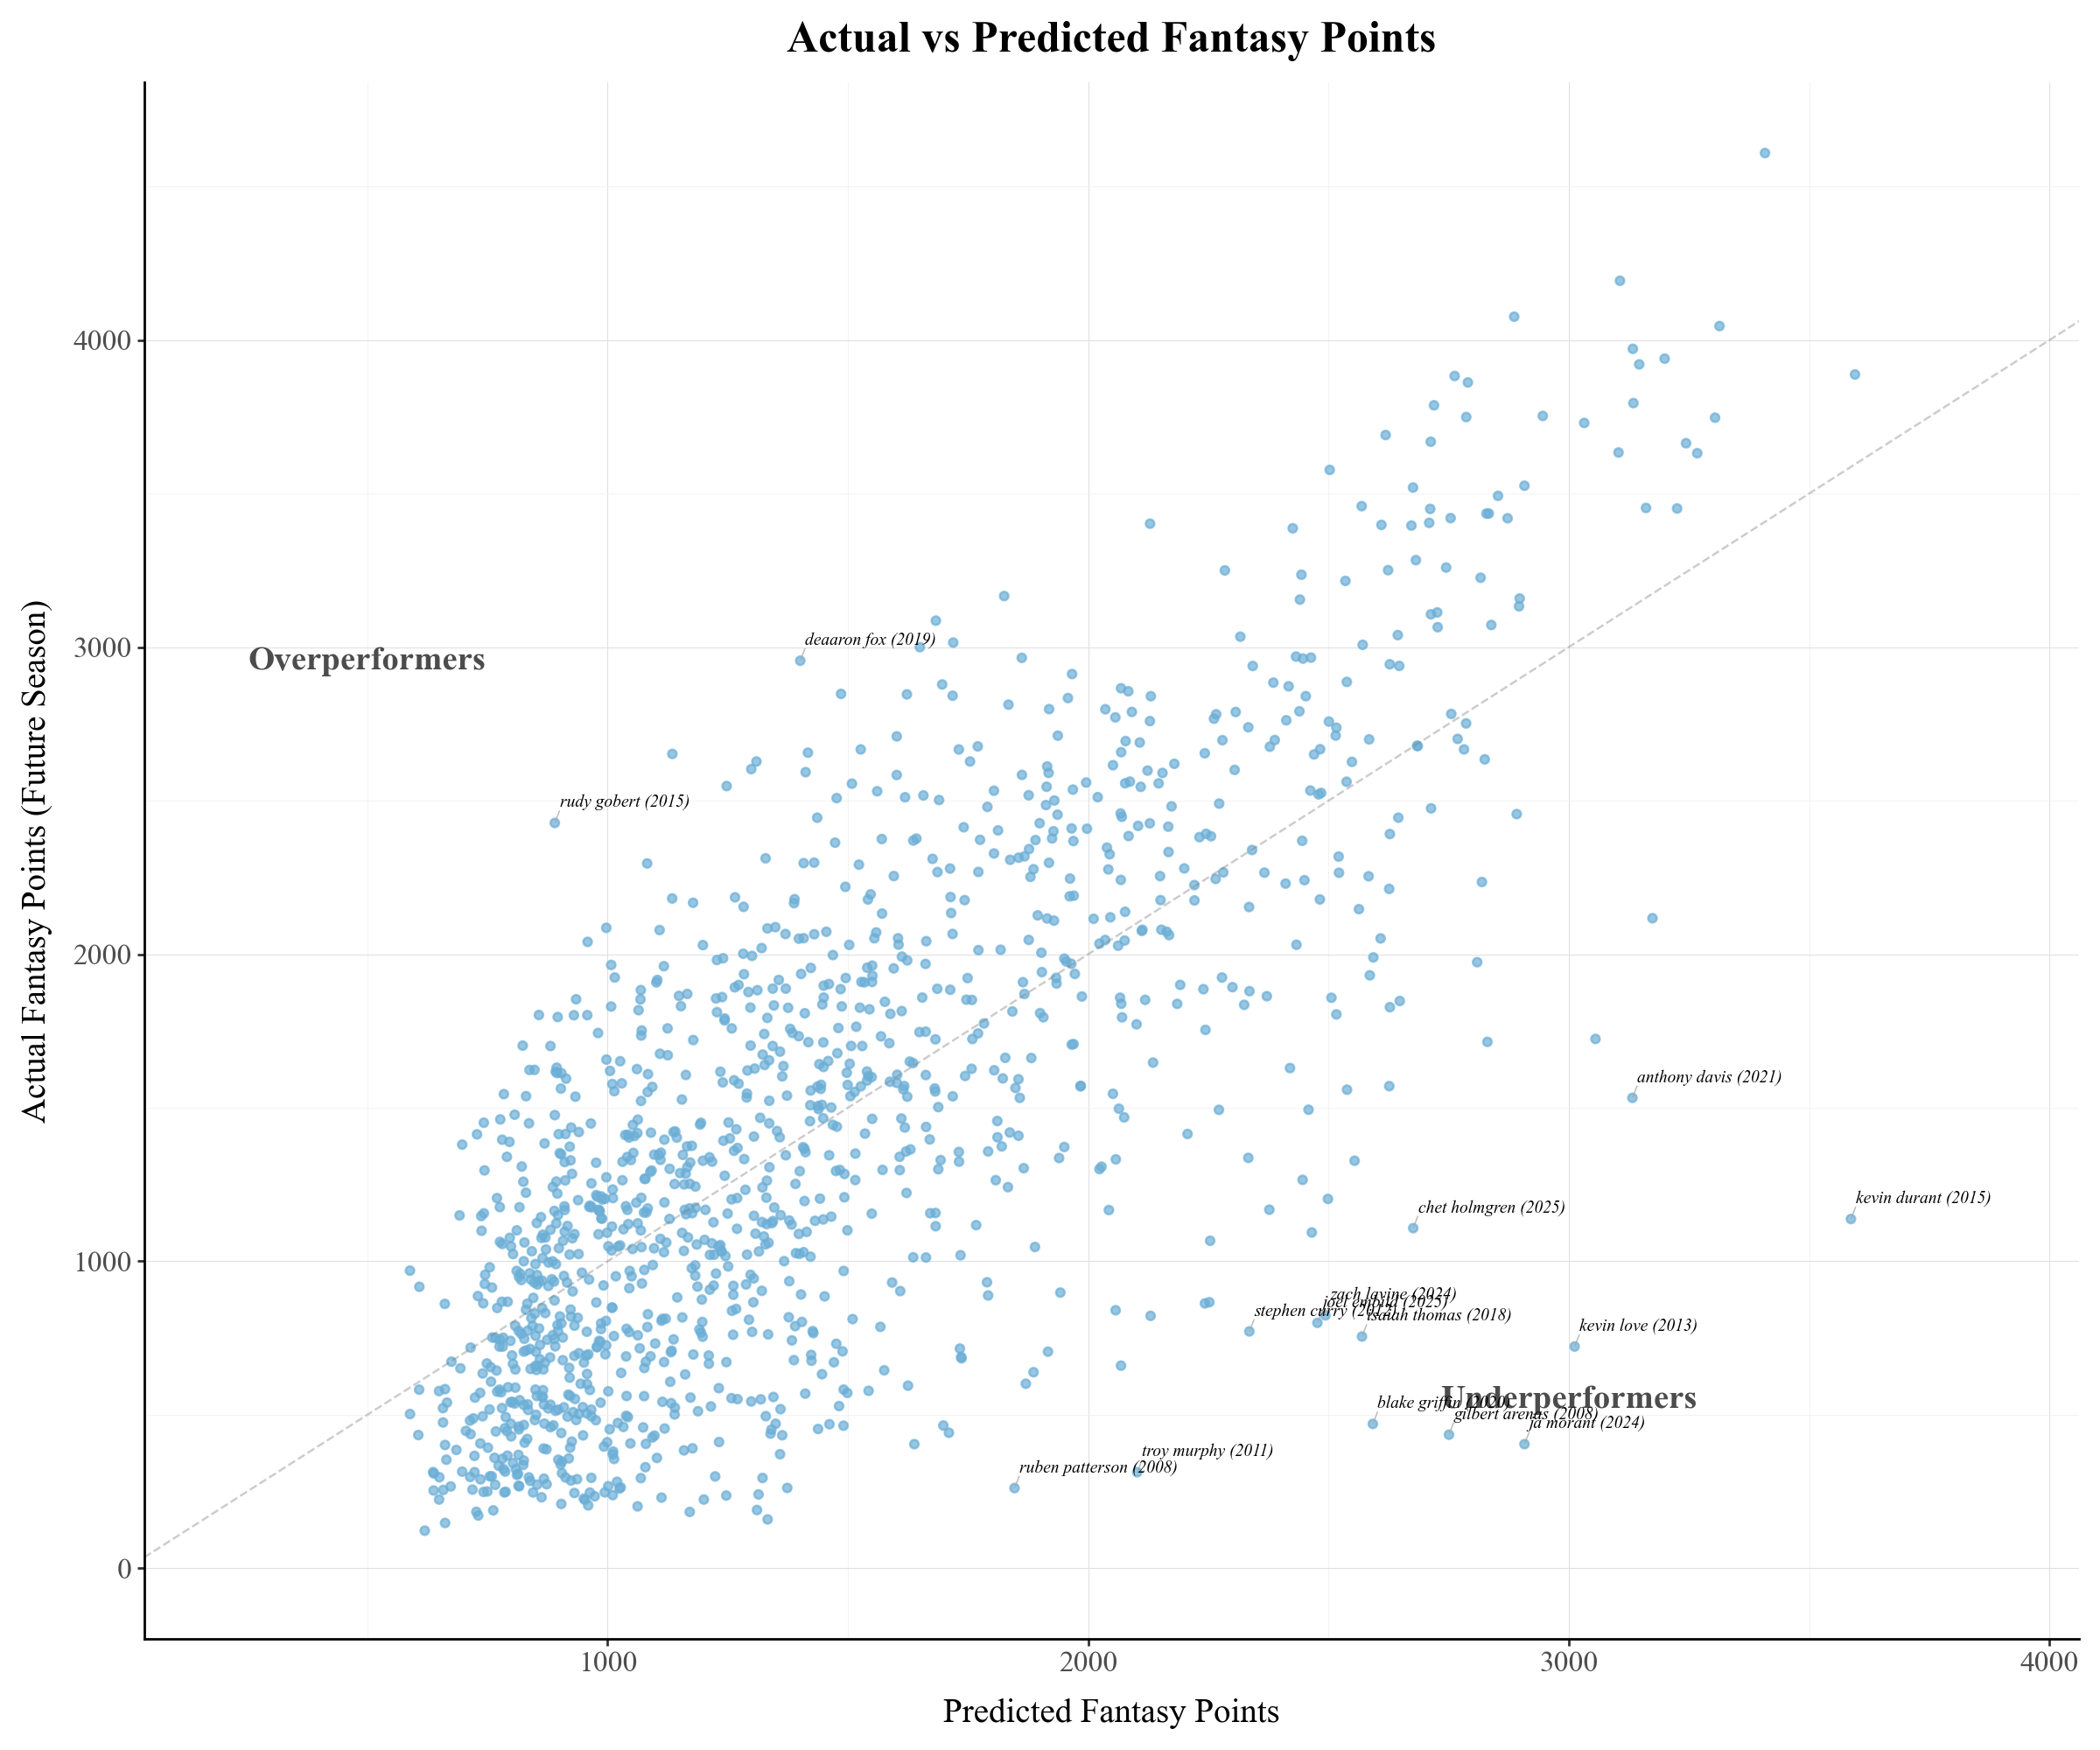

In [ ]:
## Plot for Actual vs Predicted Fantasy Points
# Top 15 largest absolute errors
top_outliers = results.reindex(
    results["prediction_diff"].abs().sort_values(ascending=False).index
).head(15)

top_outliers["year"] = (
    top_outliers["year"] + 1
)  # Adjust year to reflect predicted season

top_outliers["label"] = (
    top_outliers["player_name_clean"] + " (" + top_outliers["year"].astype(str) + ")"
)

x_offset = 10
y_offset = 40

top_outliers["label_x"] = top_outliers["predicted_fantasy_points"] + x_offset
top_outliers["label_y"] = top_outliers["fantasy_points_future"] + y_offset

p_actual_vs_pred = (
    ggplot(
        results,
        aes(
            x="predicted_fantasy_points",
            y="fantasy_points_future",
        ),
    )
    + geom_point(
        alpha=0.7,
        size=1.5,
        color=COLOR_PALETTE[0],
    )
    + geom_abline(slope=1, intercept=0, linetype="dashed", color="grey", alpha=0.4)
    + labs(
        title="Actual vs Predicted Fantasy Points",
        x="Predicted Fantasy Points",
        y="Actual Fantasy Points (Future Season)",
    )
    + geom_segment(
        top_outliers,
        aes(
            x="predicted_fantasy_points",
            y="fantasy_points_future",
            xend="label_x",
            yend="label_y",
        ),
        color="darkgrey",
        size=0.3,
        alpha=0.8,
    )
    + geom_text(
        top_outliers,
        aes(
            x="label_x",
            y="label_y",
            label="label",
        ),
        size=7,
        ha="left",
        va="bottom",
        fontstyle="italic",
    )
    # annotate region labels above / below the hline
    + annotate(
        "text",
        x=3000,
        y=500,
        label="Underperformers",
        size=14,
        ha="center",
        va="bottom",
        color="black",
        alpha=0.7,
        fontweight="bold",
    )
    + annotate(
        "text",
        x=500,
        y=3000,
        label="Overperformers",
        size=14,
        ha="center",
        va="top",
        color="black",
        alpha=0.7,
        fontweight="bold",
    )
    + scale_x_continuous(expand=(0.15, 0))
    + scale_y_continuous(limits=(0, None))
    + theme_nba()
    + theme(figure_size=(12, 10))
)
display(p_actual_vs_pred)

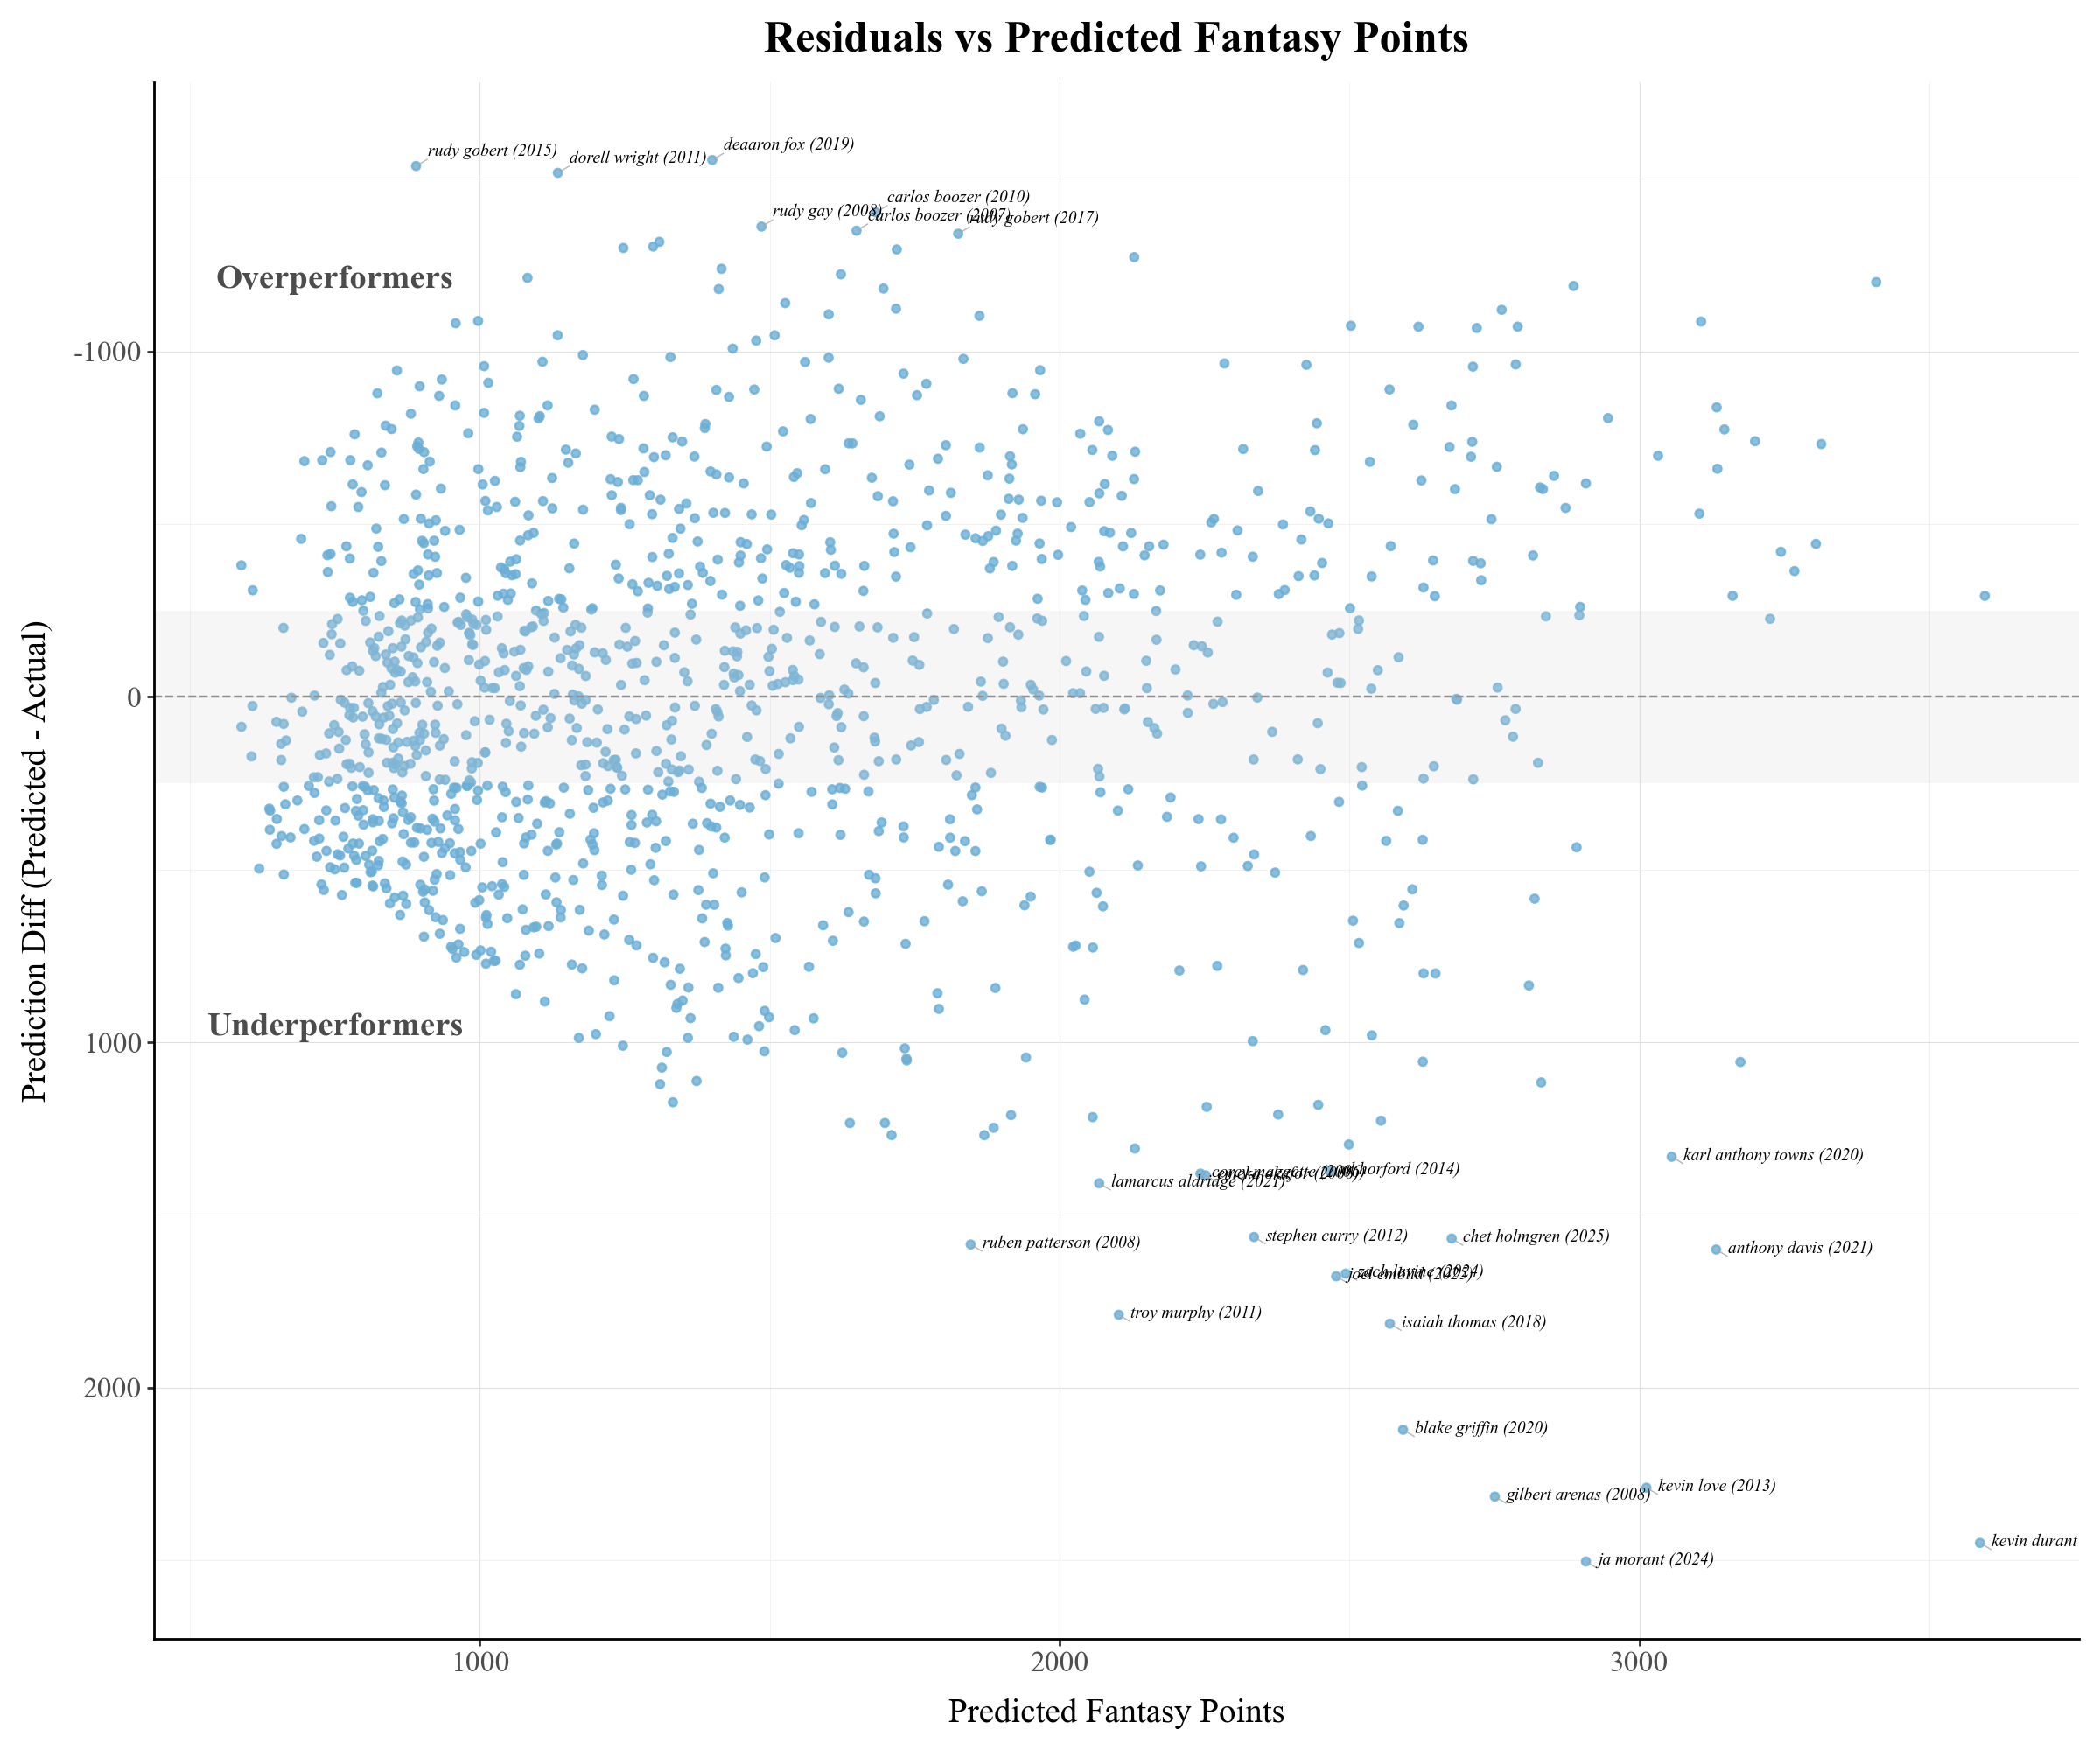

In [508]:
## Residual Plot for Actual vs Predicted Fantasy Points

# Top 25 largest absolute errors
top_outliers = results.reindex(
    results["prediction_diff"].abs().sort_values(ascending=False).index
).head(25)

top_outliers["year"] = (
    top_outliers["year"] + 1
)  # Adjust year to reflect predicted season

top_outliers["label"] = (
    top_outliers["player_name_clean"] + " (" + top_outliers["year"].astype(str) + ")"
)

x_offset = 20
y_offset = 20

top_outliers["label_x"] = top_outliers["predicted_fantasy_points"] + x_offset
# Flip y_offset direction based on sign of prediction_diff
top_outliers["label_y"] = top_outliers["prediction_diff"] + (
    y_offset * np.sign(top_outliers["prediction_diff"])
)

p_resid_vs_pred = (
    ggplot(
        results,
        aes(
            x="predicted_fantasy_points",
            y="prediction_diff",
        ),
    )
    + labs(
        title="Residuals vs Predicted Fantasy Points",
        x="Predicted Fantasy Points",
        y="Prediction Diff (Predicted - Actual)",
    )
    + geom_point(alpha=0.8, size=1.4, color=COLOR_PALETTE[0])
    + geom_hline(yintercept=0, linetype="dashed", color="grey")
    + geom_segment(
        top_outliers,
        aes(
            x="predicted_fantasy_points",
            y="prediction_diff",
            xend="label_x",
            yend="label_y",
        ),
        color="darkgrey",
        size=0.3,
        alpha=0.8,
    )
    + geom_text(
        top_outliers,
        aes(
            x="label_x",
            y="label_y",
            label="label",
        ),
        size=7,
        ha="left",
        va="bottom",
        fontstyle="italic",
    )
    # annotate region labels above / below the hline
    + annotate(
        "text",
        x=750,
        y=1000,
        label="Underperformers",
        size=14,
        ha="center",
        va="bottom",
        color="black",
        alpha=0.7,
        fontweight="bold",
    )
    + annotate(
        "text",
        x=750,
        y=-1250,
        label="Overperformers",
        size=14,
        ha="center",
        va="top",
        color="black",
        alpha=0.7,
        fontweight="bold",
    )
    # light grey shaded band between -250 and 250 on the y-axis
    + annotate(
        "rect",
        xmin=-np.inf,
        xmax=np.inf,
        ymin=-250,
        ymax=250,
        alpha=0.2,
        fill="lightgrey",
    )
    + scale_y_reverse()
    + theme_nba()
    + theme(figure_size=(12, 10))
)

p_resid_vs_pred.show()

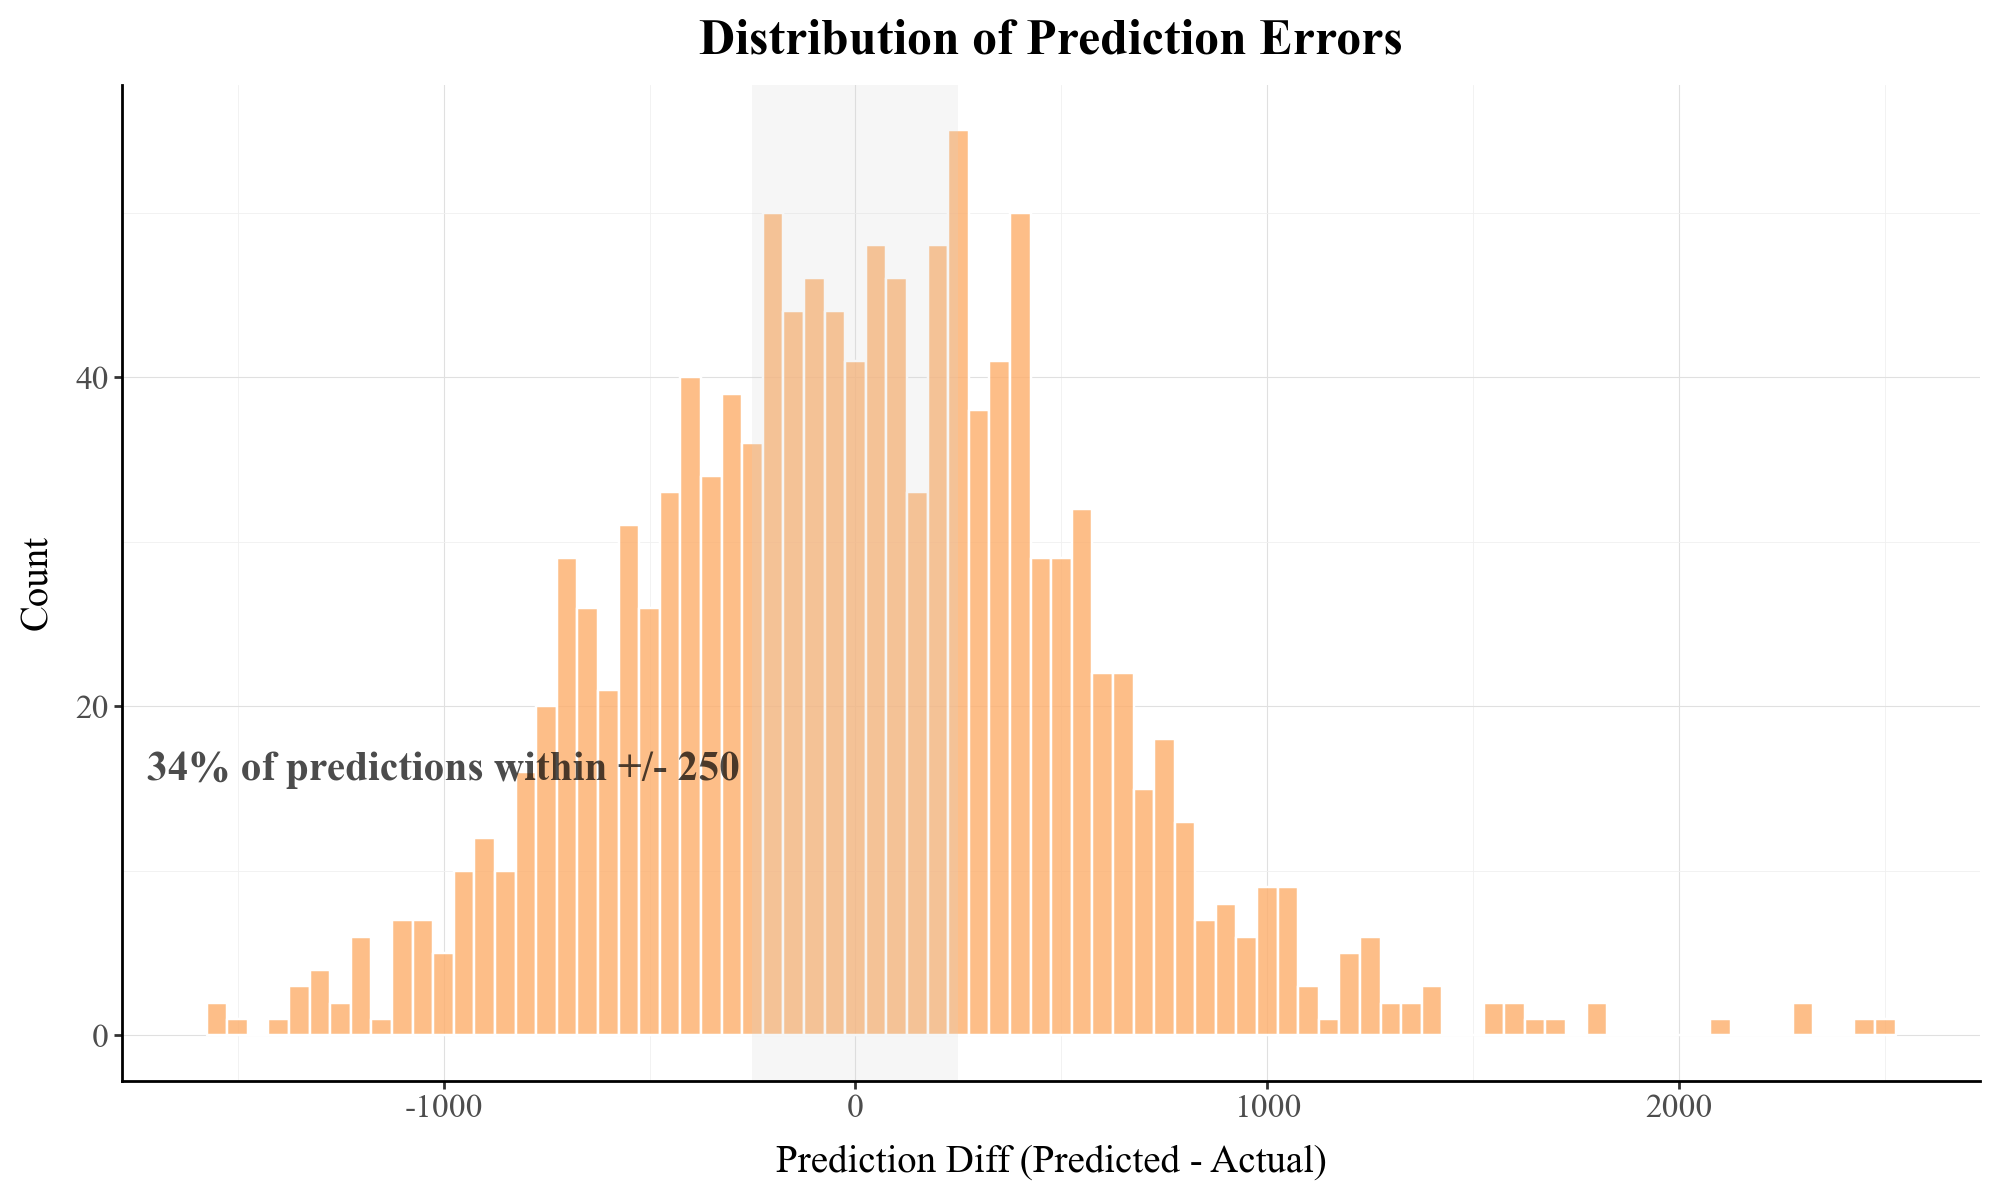

In [502]:
# Capturing the % of rows within +/- 250 prediction diff
within_250 = int((results["prediction_diff"].abs() <= 250).mean() * 100)


p_resid_hist = (
    ggplot(results, aes(x="prediction_diff"))
    + geom_histogram(binwidth=50, fill=COLOR_PALETTE[1], alpha=0.8, color="white")
    + labs(
        title="Distribution of Prediction Errors",
        x="Prediction Diff (Predicted - Actual)",
        y="Count",
    )
    # annotate % of dataset within +/- 250
    + annotate(
        "text",
        x=-1000,
        y=15,
        label=f"{within_250}% of predictions within +/- 250",
        size=15,
        ha="center",
        va="bottom",
        color="black",
        alpha=0.7,
        fontweight="bold",
    )
    # light grey shaded band between -250 and 250 on the y-axis
    + annotate(
        "rect",
        xmin=-250,
        xmax=250,
        ymin=-np.inf,
        ymax=np.inf,
        alpha=0.2,
        fill="lightgrey",
    )
    + theme_nba()
)

p_resid_hist.show()

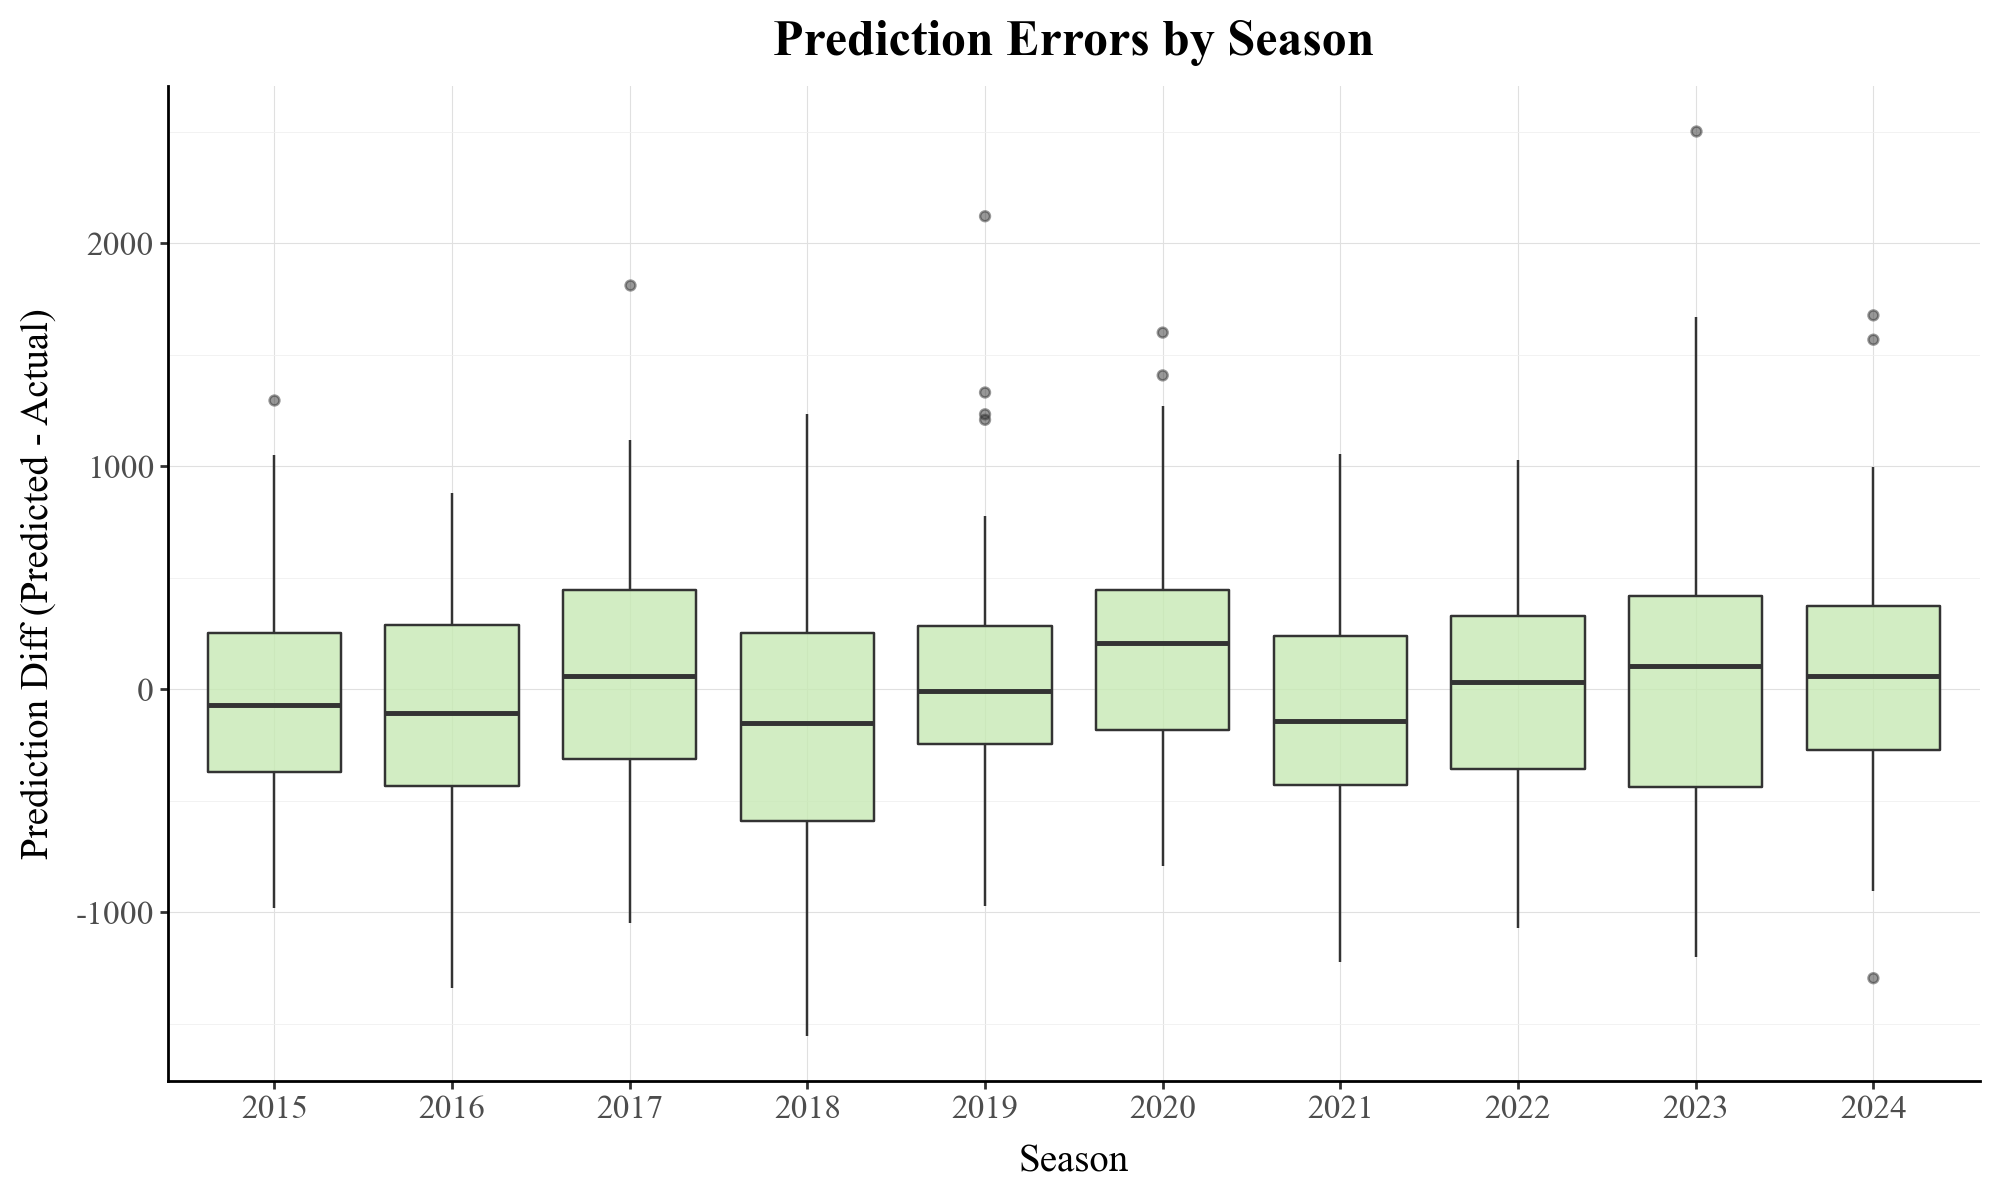

In [503]:
# Only plotting boxplots for last 10 seasons
recent_years = results["year"].max() - 10
results_recent = results[results["year"] > recent_years].copy()

p_resid_by_year = (
    ggplot(results_recent, aes(x="factor(year)", y="prediction_diff"))
    + geom_boxplot(fill=COLOR_PALETTE[2], alpha=0.8, outlier_alpha=0.5)
    + labs(
        title="Prediction Errors by Season",
        x="Season",
        y="Prediction Diff (Predicted - Actual)",
    )
    + theme_nba()
)
p_resid_by_year.show()

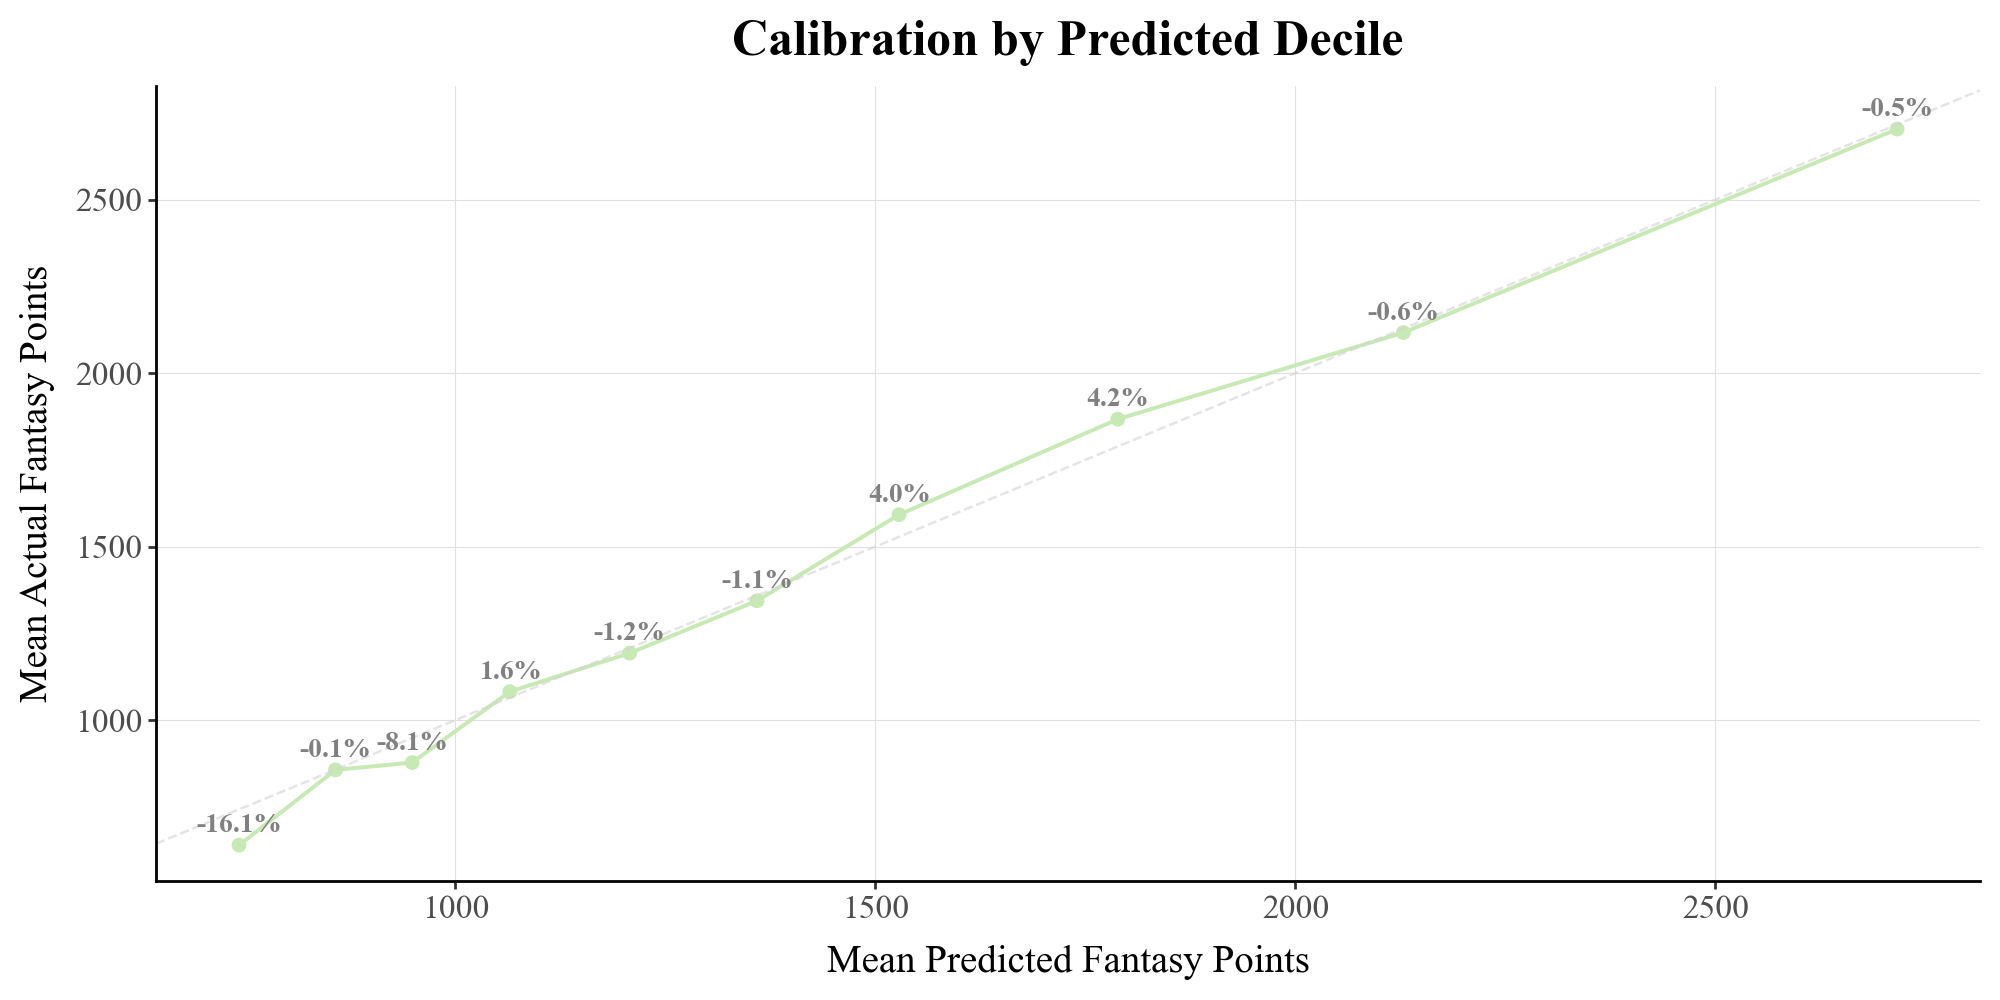

In [504]:
results["pred_decile"] = pd.qcut(
    results["predicted_fantasy_points"],
    q=10,
    labels=False,
)

decile_calib = results.groupby("pred_decile", as_index=False).agg(
    mean_pred=("predicted_fantasy_points", "mean"),
    mean_actual=("fantasy_points_future", "mean"),
)

decile_diff = decile_calib.assign(
    diff=lambda df: ((df["mean_pred"] - df["mean_actual"]) / df["mean_actual"] * 100)
)
# Adjusting diff to be a string with % sign and rounded to 1 decimal place
decile_diff["diff"] = (-decile_diff["diff"].round(1).astype(float)).astype(str) + "%"

p_decile_calib = (
    ggplot(decile_calib, aes(x="mean_pred", y="mean_actual"))
    + geom_point(fill=COLOR_PALETTE[2], color=COLOR_PALETTE[2], size=2)
    + geom_line(color=COLOR_PALETTE[2], alpha=1, size=0.8)
    + geom_abline(slope=1, intercept=0, linetype="dashed", color="lightgrey", alpha=0.6)
    + geom_text(
        decile_diff,
        aes(x="mean_pred", y="mean_actual", label="diff"),
        va="bottom",
        ha="center",
        color="grey",
        fontweight="bold",
        size=10,
        nudge_y=20,
    )
    + labs(
        title="Calibration by Predicted Decile",
        x="Mean Predicted Fantasy Points",
        y="Mean Actual Fantasy Points",
    )
    + theme_nba()
    + theme(figure_size=(10, 5), panel_grid_minor=element_blank())
)

p_decile_calib.show()

In [509]:
# Making final predictions & adding them back onto the prediction dataframe
pred_values = final_model.predict(X_pred)

df_pred["predicted_fantasy_points"] = pred_values

display(
    df_pred[["player_name_clean", "year", "predicted_fantasy_points"]].sort_values(
        by="predicted_fantasy_points", ascending=False
    )
)

,player_name_clean,year,predicted_fantasy_points
7803,shai gilgeous alexander,2025,3514.209717
7750,nikola jokic,2025,3426.915527
7569,giannis antetokounmpo,2025,3300.488525
7453,anthony edwards,2025,2817.801270
7483,cade cunningham,2025,2809.819580
...,...,...,...
7782,reggie jackson,2025,616.120911
7465,bismack biyombo,2025,615.093079
7823,torrey craig,2025,614.163391
7727,maxi kleber,2025,608.859436


In [407]:
def scrape_fp_projections(url: str = FANTASYPROS_URL) -> pd.DataFrame:
    """
    Scrape the FantasyPros NBA overall rankings table and return as a DataFrame.
    Uses requests + BeautifulSoup to find the table with id="data".
    """
    # Fetch the page with a browser-like User-Agent
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(url, headers=headers)
    response.raise_for_status()

    soup = BeautifulSoup(response.text, "html.parser")

    # Find the main data table (FantasyPros consistently uses id="data" on these pages)
    table = soup.find("table", {"id": "data"})
    if table is None:
        raise ValueError("Could not find table with id='data' on FantasyPros page.")

    # Extract header cells
    thead = table.find("thead")
    header_cells = thead.find_all("th")
    headers = [th.get_text(strip=True) for th in header_cells]

    # Extract body rows
    tbody = table.find("tbody")
    rows = []
    for tr in tbody.find_all("tr"):
        cells = [td.get_text(strip=True) for td in tr.find_all("td")]
        # Some rows may be empty / separators
        if cells:
            rows.append(cells)

    # Build DataFrame
    df = pd.DataFrame(rows, columns=headers)

    return df

In [ ]:
def clean_name_fp(name: str) -> str:
    """
    Convert a FantasyPros player string into a normalized 'player_name_clean'-style string.
    Example: 'Nikola Jokic (DEN - C)' -> 'nikola jokic'
    """
    if not isinstance(name, str):
        return ""

    # Remove accents (é -> e, etc.)
    name = unicodedata.normalize("NFKD", name).encode("ascii", "ignore").decode("ascii")

    # Remove everything after the last closing parenthesis
    last_paren = name.rfind(")")
    if last_paren != -1:
        name = name[: last_paren + 1]

    # Drop anything in parentheses, e.g., " (DEN - C)"
    name = re.sub(r"\s*\(.*?\)", "", name)

    # Collapse whitespace & lowercase
    name = re.sub(r"\s+", " ", name).strip().lower()

    # Apply prior clean_name process to name
    name = clean_name(name)

    return name

In [ ]:
def prepare_fantasypros_df() -> pd.DataFrame:
    """
    Scrape FantasyPros overall rankings and produce a cleaned dataframe
    with a `player_name_clean` column ready to join.
    """
    fp_raw = scrape_fp_projections(FANTASYPROS_URL)

    # Normalize column names to snake_case
    fp = fp_raw.copy()
    fp.columns = (
        fp.columns.astype(str)
        .str.strip()
        .str.lower()
        .str.replace(" ", "_")
        .str.replace("%", "pct")
    )

    # FantasyPros normally has a 'player' column
    if "player" not in fp.columns:
        raise ValueError(
            f"'player' column not found in FantasyPros DF. Columns: {fp.columns.tolist()}"
        )

    # Create player_name_clean
    fp["player_name_clean"] = fp["player"].apply(clean_name_fp)

    # Apply your existing name overrides if you want alignment with other sources
    # (assumes name_overrides dict is already defined in your notebook)
    if "name_overrides" in globals():
        fp["player_name_clean"] = fp["player_name_clean"].replace(name_overrides)

    # Try to identify a rank column and standardize its name
    rank_col_candidates = [c for c in fp.columns if "rank" in c or c == "rk"]
    if rank_col_candidates:
        fp = fp.rename(columns={rank_col_candidates[0]: "fp_rank"})

    return fp

In [411]:
fp_df = prepare_fantasypros_df()
fp_df.head()

,player,pts,reb,ast,blk,stl,fgpct,ftpct,3pm,to,gp,min,ftm,2pm,a/to,pf,player_name_clean
0,Shai Gilgeous-Alexander(OKC - PG)OUT,754,109,148,16,33,.556,.881,51,39,23,767,207,197,3.79,46,shai gilgeous alexander
1,"Donovan Mitchell(CLE - PG,SG)DTD",702,111,126,7,32,.502,.836,92,78,23,789,122,152,1.62,55,donovan mitchell
2,"Tyrese Maxey(PHI - PG,SG)",696,102,156,19,38,.467,.886,79,58,22,878,147,156,2.69,51,tyrese maxey
3,Nikola Jokic(DEN - C),643,273,242,18,30,.609,.858,44,76,22,768,139,186,3.18,62,nikola jokic
4,"Jaylen Brown(BOS - SG,SF)DTD",639,135,108,7,25,.497,.773,46,79,22,735,119,191,1.37,71,jaylen brown
